<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time-series forecasting with TensorFlow

What are we going to cover?
1. Get a time series data (the historical price of Bitcoin)
  * Load time series data using Pandas/Python CSV
2. Format data for a time series problem
  * Creating a training and test set wrong way
  * Creating a training and test set right way
  * Visualizing time series data
  * Turning time series model into supervised learning problem ( Windowing )
  * Preparing Univariate and Multivariable ( more than one variable ) data

3. Evaluating a time series model
4. Setting up a series for deep leaning modelling experiments
  * Dense fully connected
  * Sequence model ( LSTM and 1D CNN )
  * Ensembling ( combining multiple models together )
  * Multivariate models
  * Replicating the N-Beats algorithm using Tensorflow Layer subclassing
5. Creating a modelling checkpoint to save best performing model
6. Making predictions (forecast) with time series model.
7. Creating prediction intervals for time series forecasts.


## 1. Get the data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-07-30 09:55:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-07-30 09:55:22 (7.16 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### 1.1 Import time series data with Pandas

In [2]:
import pandas as pd
price_df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
                 ,parse_dates=["Date"]
                 ,index_col=["Date"]
                 )

price_df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
len(price_df)

2787

🔑note: The frequency at which time series data is collected is often referred to as **seasonality**. Seasonality is often measured as number of samples / year.

In [5]:
# We only want the closing price
daily_price_df = pd.DataFrame(price_df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
daily_price_df.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


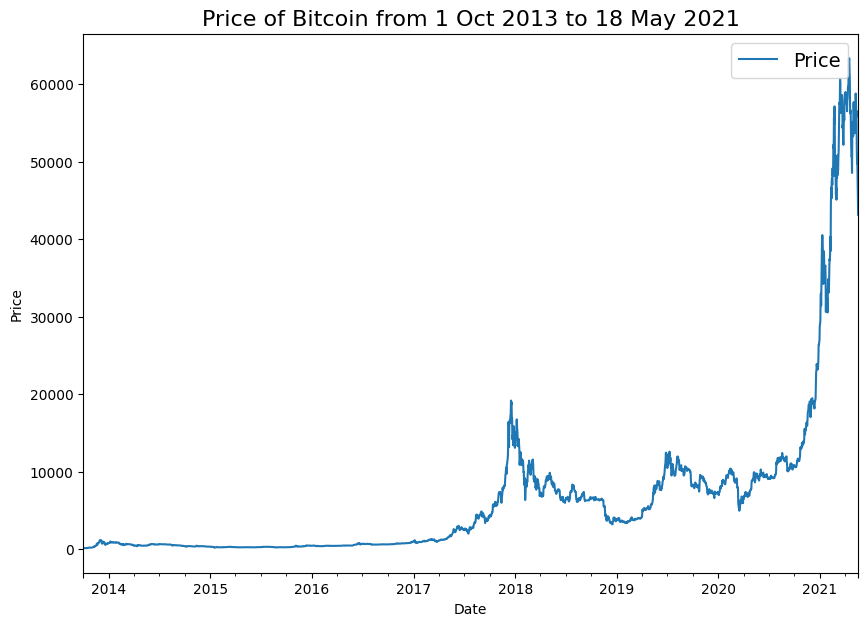

In [6]:
import matplotlib.pyplot as plt
daily_price_df.plot(figsize=(10,7))
plt.ylabel("Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## 2. Creating the training and test set
### 2.1 The wrong way

In [7]:
# Convert our dataframe index and columns to numpy arrays
timesteps = daily_price_df.index.to_numpy()
prices = daily_price_df["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(timesteps
                                                   ,prices
                                                   ,test_size=0.2
                                                   ,random_state=42)
len(X_train),len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

### 2.2 Let's visualize the splits

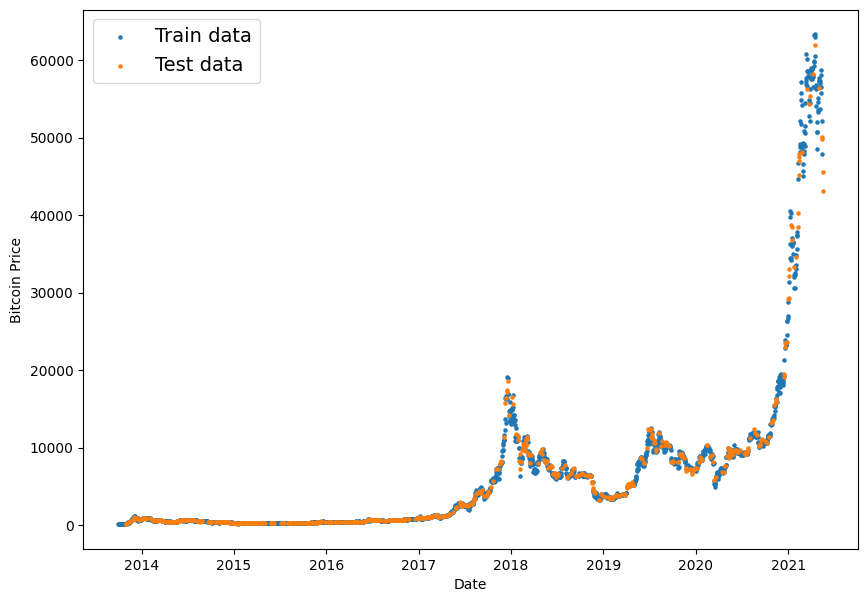

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=14)
plt.show();

As we can see in the above plot our test data is scattered across the training data. This kind of random split works great with data where there is no temporal (time) component. But when time component is invovled, we need to split the data in such a way that it should reflect our purpose. The purpose here is to analyze the historical price and predict or forecast the future price.

### 2.3 Creating the train test split the right way

In [10]:
split_size = int(0.8* len(prices))

X_train,y_train = timesteps[:split_size],prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

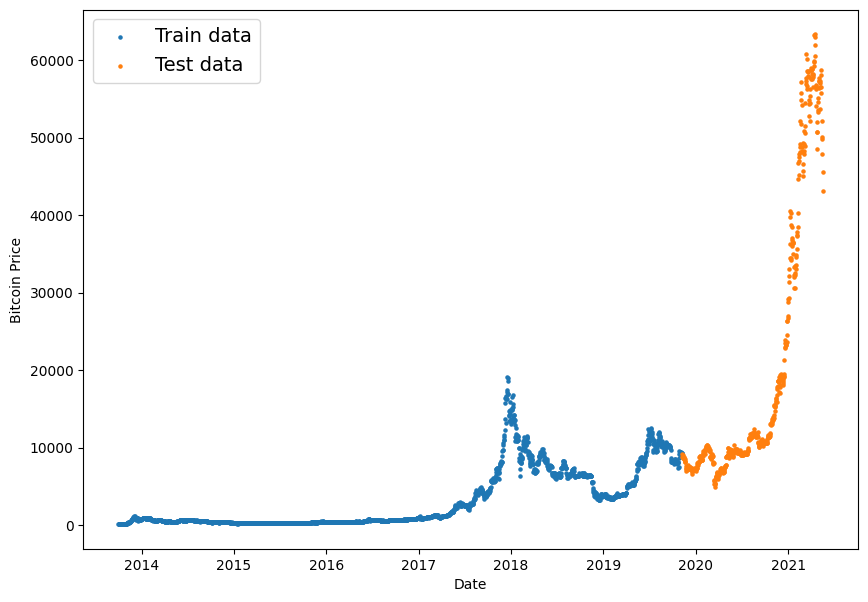

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=14)
plt.show();

## Model 0: Navive Forecast ( baseline )
As usual lets start with a baseline.
One of the most common baseline for time series forecasting, the naive model requires no training.
That's because all that the naive model does is forecast the next timestep value based on previous timestep value.
The formula looks like:

̂y<sub>t</sub> = y<sub>t</sub> -1

In [12]:
# create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10],naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [13]:
# Create a plotting function

def plot_time_series(timesteps,values,format='.', start=0, end=None, label=None):
  """
    Plots a timesteps (a series of points in time) against values ( a series of values across timesteps)

    Parameters
    -------------
    timesteps: array of timesteps
    values: array of values across time
    format: style of plot, default "."
    start: where to start the plot ( setting a value will index from start of timesteps and values)
    end: where to end the plot (setting a value will index from end of timesteps & values )
    label: label to show on plot of values
  """
  ## Plot the series
  plt.plot(timesteps[start:end],values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

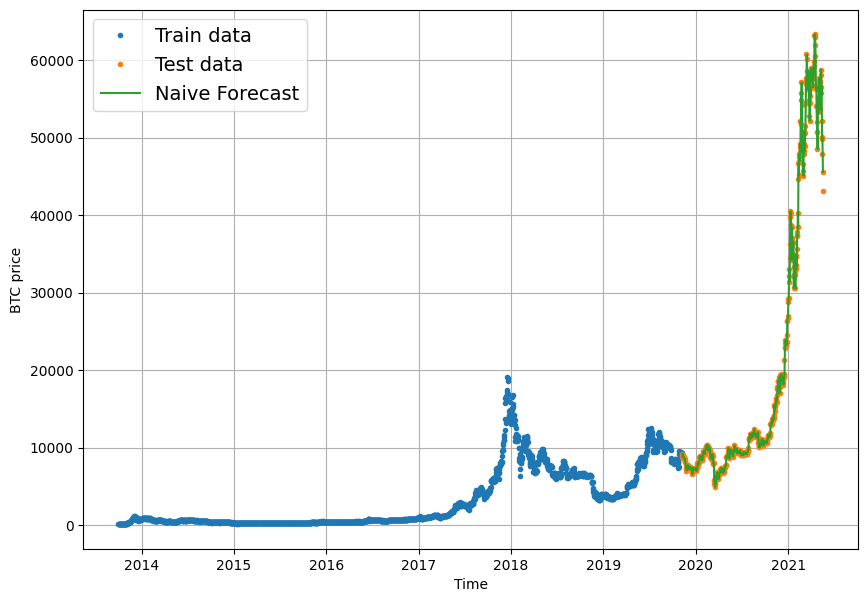

In [14]:
# Plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Train data")
plot_time_series(timesteps=X_test,values=y_test,label="Test data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",label="Naive Forecast")

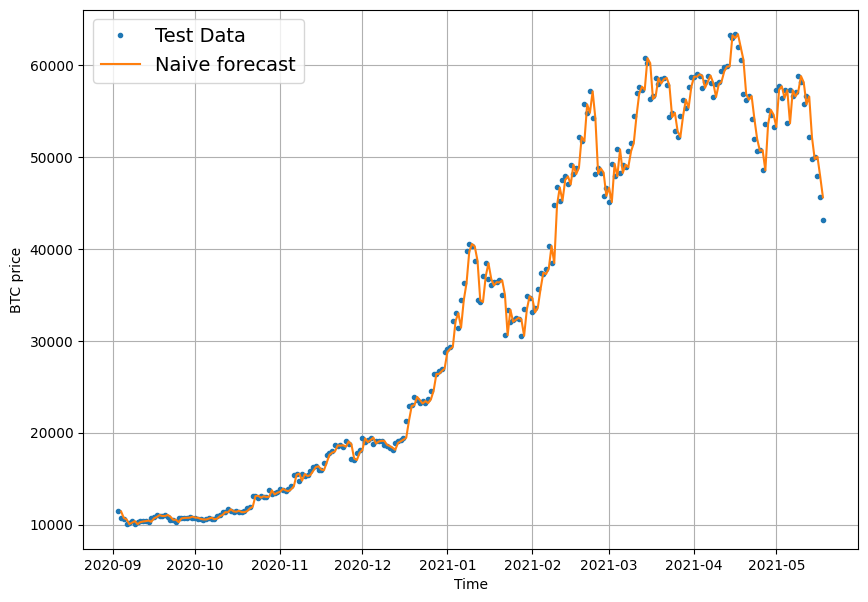

In [15]:
plt.figure(figsize=(10,7))
offset = 300
plot_time_series(timesteps=X_test,values=y_test, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast, format="-", start=offset, label="Naive forecast")

## Evaluate a time series model
Time series forecasting often involves predicting a number.
As the problem statement is about predicting a number, it comes under **regression**
For all the following metrics **lower is better** ( for e.g MAE 0 is better than MAE 100)

### Scale-depdendent errors
These are metrics which can be used to compare time series values and forecast that are on the same scale

Metrics| Details|Code
---|---|---
MAE ( Mean Absolute Error ) | Easy to interpret. Forecast methods which minimizes the <br> MAE will lead to forecasts of the median |`tf.keras.metrics.mean_absolute_error()`
RMSE(Root Mean Squared Error ) | Forecast which minimizes the RMSE lead to forecasts <br> to the mean| `tf.keras.metrics.mean_squared_error()`

### Percentage Errors
Percentage errors do not have units, which mean they can be used to compare forecasts across different units.

Metrics|Details|Code
---|---|---
**MAPE**(Mean Absolute Percentage Error)|Most commonly used percentage error|`tf.keras.metrics.mean_absolute_percentage_error`
**sMAPE**(symmetric Mean Absolute Percentage Error)| Recommend not to use|Custom implementation

### Scaled Errors
Scaled errors are alternative to percentage errors when comparing forecasting performance across different timeseries

Metrics|Details|Code
---|---|---
MASE(mean absolute scaled error)|A forecast which performs better than naive should get <1 MASE|See sktimes<br> `mase_loss()`


In [16]:
import tensorflow as tf


In [17]:
# MASE implemented
def mean_absolute_scaled_error(y_true, y_pred):
  """
    Implement MASE ( assuming no seasonality data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  ## find MAE for naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1]))

  return mae/mae_naive_no_season

> In practice the naive model should achieve an MASE of 1 (or very close to 1). Any model worse than the naive forecast will achieve an MASE of > 1 and any model better than naive forecast will achieve and MASE of < 1

Let's put each of our different evaluation metrics together into a function

In [18]:
def evaluate_pred(y_true,y_pred):
  #Make sure float32 ( for metric calculation)
  y_true= tf.cast(y_true,dtype=tf.float32)
  y_pred= tf.cast(y_pred,dtype=tf.float32)

  # Calculate various metrics
  mae= tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse= tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse= tf.sqrt(mse)
  mape= tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase= mean_absolute_scaled_error(y_true,y_pred)

  return {
      "mae": mae.numpy()
      ,"mse": mse.numpy()
      ,"rmse": rmse.numpy()
      ,"mape": mape.numpy()
      ,"mase": mase.numpy()
  }

In [19]:
naive_results= evaluate_pred(y_true=y_test[1:]
                             ,y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Looking at the MAE results, we can infer that on an average the predicted bitcoin price is off from the actual price by about ~567 USD.

## Format Data Part2: Windowing dataset
**Windowing** is a method to turn a time series dataset to _supervised learning problem_.
In other words, we want to use windows of the past to predict the future.
For example, for a univariate time series, windowing for one week(`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]
```

Let's write a function that can take a univariate time series and turn into windows and horizon of specified sizes.

We'll start the default horizon size of 1 and window size of 7


In [20]:
HORIZON= 1 # predict 1 timestep at a time
WINDOW_SIZE= 7 #use a week worth of timesteps to predict the horizon

Now we will write a function that will take an array and return a window and horizon


In [21]:
# Create a function to create labelled window data
def get_labelled_windows(x,horizon=1):
  """
    Creates a label for window dataset
    E.g if horizon=1 (default)
    Input: [1,2,3,4,5,6] -> Output ([1,2,3,4,5],[6])
  """
  return (x[:,:-horizon],x[:, -horizon:])

In [22]:
# Test the window labelling function
test_window, test_label= get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0),horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


#### Make window for the entire timeseries
Let's write a function which:
1. Create a window step of specific window size, for example `[[0,1,2,3,4,5,6]]`
2. Uses [Numpy Indexing]() to create a 2D of multiple window steps, for example
```
[[0,1,2,3,4,5,6,7]
 [1,2,3,4,5,6,7,8]
 [2,3,4,5,6,7,8,9]]
```
3. Uses the 2D array of multiple window steps to index to a target series.
4. Uses the `get_labelled_window` function we created above to turn the window steps into windows with a specified horizon.

In [23]:
import numpy as np

In [24]:
# Create a function to view Numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
   Turns a 1D array into a 2D array of sequential windows of a given window size.
  """
  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step= np.expand_dims(np.arange(window_size+horizon),axis=0)
  # 2. Create a 2D array of multiple window steps
  window_indexes= window_step+ np.expand_dims(np.arange(len(x)- (window_size+horizon-1)),axis=0).T
  # 3. Index on the target array with 2D array of multiple window steps
  windowed_array= x[window_indexes]
  # 4. Get the labelled windows
  windows, labels= get_labelled_windows(windowed_array,horizon=horizon)
  return windows,labels

In [25]:
np.expand_dims(np.arange(7+1),0).T

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]])

In [26]:
full_windows, full_labels= make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [27]:
## view the first 3 windows/labels
for i in range(3):
  print(f" Window: {full_windows[i]}, Label: {full_labels[i]}")

 Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], Label: [123.033]
 Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ], Label: [124.049]
 Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ], Label: [125.96116]


We can use tensorflow inbuilt functions to achieve the same output. We need to use `tf.keras.preprocessing.timeseries_dataset_from_array()`

TODO: We will look into this later.

### Turning windows into training and test set
Let's write a function that takes a full set of windows and their labels and splits them into train & test splits.

In [28]:
# Make the train/test split
def make_train_test_split(windows,labels,test_split=0.2):
  """
    Splits matching pairs of windows and labels into train and test split.

  """
  split_size= int(len(windows) * (1-test_split))

  train_windows= windows[:split_size]
  train_labels= labels[:split_size]
  test_windows= windows[split_size:]
  test_labels= labels[split_size:]

  return train_windows, train_labels, test_windows,test_labels


In [29]:
train_windows, train_labels, test_windows,test_labels = make_train_test_split(full_windows,full_labels)
len(train_windows), len(test_windows),  len(train_labels),len(test_labels)


(2224, 556, 2224, 556)

In [30]:
train_windows[:5],train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Making a model checkpoint
The `ModelCheckpoint` callback will monitor our model performance during the training and saves the best model to the file system by setting `save_best_only=True`

In [31]:
import os
# create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name,save_path="model_experiment"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name)
                                            ,verbose=0
                                            ,save_best_only=True)

## Model 1: Dense Model ( window = 7, horizon = 1)
Time to build one of our models

`model_1` will have:
* A single dense layer with 128 hidden units and ReLU activation unit.
* An output layer with linear activation.
* Adam optimizer with MAE loss
* Batch size of 128
* 100 epochs

In [32]:
import tensorflow as tf
from tensorflow.keras import layers

## set seed
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation=tf.keras.activations.relu)
    ,layers.Dense(HORIZON,activation=tf.keras.activations.linear)
],name="model_1_dense")

model_1.compile(loss=tf.keras.losses.mean_absolute_error
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"]
                )

history_1= model_1.fit(x=train_windows
                       ,y=train_labels
                       ,epochs=100
                       ,verbose=1
                       ,batch_size=128
                       ,validation_data=(test_windows,test_labels)
                       ,callbacks=[create_model_checkpoint(model_name=model_1.name)]
                       )



Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 2873.0239 - mae: 2873.0239

18/18 [==============================] - 11s 134ms/step - loss: 2835.6980 - mae: 2835.6980 - val_loss: 6682.9419 - val_mae: 6682.9419
Epoch 2/100
11/18 [=================>............] - ETA: 0s - loss: 460.2589 - mae: 460.2589

18/18 [==============================] - 1s 66ms/step - loss: 448.9760 - mae: 448.9760 - val_loss: 1507.2073 - val_mae: 1507.2073
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 246.5317 - mae: 246.5317

18/18 [==============================] - 2s 100ms/step - loss: 237.9234 - mae: 237.9234 - val_loss: 1204.2651 - val_mae: 1204.2651
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 217.6482 - mae: 217.6482

18/18 [==============================] - 1s 75ms/step - loss: 217.6482 - mae: 217.6482 - val_loss: 1172.0566 - val_mae: 1172.0566
Epoch 5/100
14/18 [======================>.......] - ETA: 0s - loss: 214.0701 - mae: 214.0701

18/18 [==============================] - 1s 57ms/step - loss: 207.2975 - mae: 207.2975 - val_loss: 1147.7151 - val_mae: 1147.7151
Epoch 6/100
11/18 [=================>............] - ETA: 0s - loss: 203.0256 - mae: 203.0256

18/18 [==============================] - 1s 55ms/step - loss: 205.6305 - mae: 205.6305 - val_loss: 1144.5334 - val_mae: 1144.5334
Epoch 7/100
14/18 [======================>.......] - ETA: 0s - loss: 211.8719 - mae: 211.8719

18/18 [==============================] - 1s 55ms/step - loss: 202.8961 - mae: 202.8961 - val_loss: 1112.5192 - val_mae: 1112.5192
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 180.0210 - mae: 180.0210

18/18 [==============================] - 1s 31ms/step - loss: 195.2772 - mae: 195.2772 - val_loss: 1110.8214 - val_mae: 1110.8214
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 166.3285 - mae: 166.3285

18/18 [==============================] - 1s 41ms/step - loss: 190.6561 - mae: 190.6561 - val_loss: 1070.6410 - val_mae: 1070.6410
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 204.2136 - mae: 204.2136

18/18 [==============================] - 1s 30ms/step - loss: 188.0182 - mae: 188.0182 - val_loss: 1064.1525 - val_mae: 1064.1525
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 201.5826 - mae: 201.5826

18/18 [==============================] - 1s 30ms/step - loss: 183.9348 - mae: 183.9348 - val_loss: 1016.0664 - val_mae: 1016.0664
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 183.0199 - mae: 183.0199 - val_loss: 1018.9527 - val_mae: 1018.9527
Epoch 13/100
13/18 [====================>.........] - ETA: 0s - loss: 173.9374 - mae: 173.9374

18/18 [==============================] - 1s 44ms/step - loss: 175.3153 - mae: 175.3153 - val_loss: 996.6891 - val_mae: 996.6891
Epoch 14/100
15/18 [========================>.....] - ETA: 0s - loss: 167.2976 - mae: 167.2976

18/18 [==============================] - 1s 44ms/step - loss: 170.1665 - mae: 170.1665 - val_loss: 961.3881 - val_mae: 961.3881
Epoch 15/100
13/18 [====================>.........] - ETA: 0s - loss: 163.3573 - mae: 163.3573

18/18 [==============================] - 1s 44ms/step - loss: 166.3838 - mae: 166.3838 - val_loss: 959.4232 - val_mae: 959.4233
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 150.4798 - mae: 150.4798

18/18 [==============================] - 0s 29ms/step - loss: 161.5027 - mae: 161.5027 - val_loss: 896.8899 - val_mae: 896.8899
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 151.9758 - mae: 151.9758

18/18 [==============================] - 1s 31ms/step - loss: 157.3554 - mae: 157.3554 - val_loss: 884.0859 - val_mae: 884.0859
Epoch 18/100
18/18 [==============================] - 0s 4ms/step - loss: 154.1546 - mae: 154.1546 - val_loss: 900.7894 - val_mae: 900.7894
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 91.6125 - mae: 91.6125

18/18 [==============================] - 1s 30ms/step - loss: 149.5748 - mae: 149.5748 - val_loss: 866.1062 - val_mae: 866.1062
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 161.2700 - mae: 161.2700

18/18 [==============================] - 1s 31ms/step - loss: 147.8690 - mae: 147.8690 - val_loss: 824.6497 - val_mae: 824.6497
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 205.3896 - mae: 205.3896

18/18 [==============================] - 1s 30ms/step - loss: 146.8034 - mae: 146.8034 - val_loss: 800.7872 - val_mae: 800.7872
Epoch 22/100
16/18 [=========================>....] - ETA: 0s - loss: 143.4390 - mae: 143.4390

18/18 [==============================] - 1s 32ms/step - loss: 141.1393 - mae: 141.1393 - val_loss: 785.0734 - val_mae: 785.0734
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 155.2760 - mae: 155.2760

18/18 [==============================] - 1s 30ms/step - loss: 138.3955 - mae: 138.3955 - val_loss: 778.4491 - val_mae: 778.4491
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 146.9744 - mae: 146.9744

18/18 [==============================] - 1s 31ms/step - loss: 138.6060 - mae: 138.6060 - val_loss: 766.6047 - val_mae: 766.6047
Epoch 25/100
18/18 [==============================] - ETA: 0s - loss: 142.7392 - mae: 142.7392

18/18 [==============================] - 1s 30ms/step - loss: 142.7392 - mae: 142.7392 - val_loss: 748.2049 - val_mae: 748.2049
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 135.0745 - mae: 135.0745 - val_loss: 768.3527 - val_mae: 768.3527
Epoch 27/100
15/18 [========================>.....] - ETA: 0s - loss: 135.3840 - mae: 135.3840

18/18 [==============================] - 1s 45ms/step - loss: 136.3140 - mae: 136.3140 - val_loss: 737.2625 - val_mae: 737.2625
Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 130.9350 - mae: 130.9350

18/18 [==============================] - 1s 30ms/step - loss: 130.9350 - mae: 130.9350 - val_loss: 712.4337 - val_mae: 712.4337
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 128.7064 - mae: 128.7064 - val_loss: 718.8016 - val_mae: 718.8016
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 151.5486 - mae: 151.5486

18/18 [==============================] - 1s 30ms/step - loss: 130.5957 - mae: 130.5957 - val_loss: 704.7554 - val_mae: 704.7554
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 126.5492 - mae: 126.5492 - val_loss: 721.2632 - val_mae: 721.2632
Epoch 32/100
18/18 [==============================] - 0s 6ms/step - loss: 126.6433 - mae: 126.6433 - val_loss: 704.7615 - val_mae: 704.7615
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 123.4486 - mae: 123.4486 - val_loss: 712.3097 - val_mae: 712.3097
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 152.2952 - mae: 152.2952

18/18 [==============================] - 0s 29ms/step - loss: 124.7708 - mae: 124.7708 - val_loss: 679.9992 - val_mae: 679.9992
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 106.1575 - mae: 106.1575

18/18 [==============================] - 1s 31ms/step - loss: 123.7954 - mae: 123.7954 - val_loss: 679.0661 - val_mae: 679.0661
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 124.5282 - mae: 124.5282 - val_loss: 685.2820 - val_mae: 685.2820
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 145.8463 - mae: 145.8463

18/18 [==============================] - 1s 29ms/step - loss: 122.8093 - mae: 122.8093 - val_loss: 652.7798 - val_mae: 652.7798
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 115.4334 - mae: 115.4334

18/18 [==============================] - 1s 30ms/step - loss: 119.5940 - mae: 119.5940 - val_loss: 644.4767 - val_mae: 644.4767
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 118.5806 - mae: 118.5806 - val_loss: 686.8647 - val_mae: 686.8647
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 119.0405 - mae: 119.0405

18/18 [==============================] - 0s 28ms/step - loss: 117.6018 - mae: 117.6018 - val_loss: 641.7003 - val_mae: 641.7003
Epoch 41/100
18/18 [==============================] - 0s 8ms/step - loss: 117.6458 - mae: 117.6458 - val_loss: 661.8568 - val_mae: 661.8568
Epoch 42/100
11/18 [=================>............] - ETA: 0s - loss: 123.1356 - mae: 123.1356

18/18 [==============================] - 1s 45ms/step - loss: 121.3113 - mae: 121.3113 - val_loss: 628.5409 - val_mae: 628.5409
Epoch 43/100
14/18 [======================>.......] - ETA: 0s - loss: 111.9172 - mae: 111.9172

18/18 [==============================] - 1s 44ms/step - loss: 115.5635 - mae: 115.5635 - val_loss: 624.2567 - val_mae: 624.2567
Epoch 44/100
14/18 [======================>.......] - ETA: 0s - loss: 111.5385 - mae: 111.5385

18/18 [==============================] - 1s 41ms/step - loss: 114.8751 - mae: 114.8751 - val_loss: 615.0638 - val_mae: 615.0638
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 114.2440 - mae: 114.2440 - val_loss: 620.0316 - val_mae: 620.0316
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 115.1075 - mae: 115.1075 - val_loss: 625.0235 - val_mae: 625.0235
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 118.1982 - mae: 118.1982 - val_loss: 768.5108 - val_mae: 768.5108
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 115.8072 - mae: 115.8072 - val_loss: 625.8115 - val_mae: 625.8115
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 164.5792 - mae: 164.5792

18/18 [==============================] - 1s 30ms/step - loss: 113.1944 - mae: 113.1944 - val_loss: 603.6222 - val_mae: 603.6222
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 113.2398 - mae: 113.2398 - val_loss: 606.1209 - val_mae: 606.1209
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 90.0851 - mae: 90.0851

18/18 [==============================] - 1s 30ms/step - loss: 111.4802 - mae: 111.4802 - val_loss: 595.9531 - val_mae: 595.9531
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5566 - mae: 112.5566 - val_loss: 597.3295 - val_mae: 597.3295
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6023 - mae: 114.6023 - val_loss: 626.8100 - val_mae: 626.8100
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 118.0371 - mae: 118.0371 - val_loss: 649.0179 - val_mae: 649.0179
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 113.6125 - mae: 113.6125 - val_loss: 598.4131 - val_mae: 598.4131
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 109.7633 - mae: 109.7633 - val_loss: 680.7759 - val_mae: 680.7759
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 114.1863 - mae: 114.1863 - val_loss: 599.8311 - val_mae: 599.8311
Epoch 58/100
18/18 [============

18/18 [==============================] - 1s 30ms/step - loss: 110.0622 - mae: 110.0622 - val_loss: 581.0162 - val_mae: 581.0162
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 108.5182 - mae: 108.5182 - val_loss: 606.4975 - val_mae: 606.4975
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 113.7776 - mae: 113.7776 - val_loss: 623.6263 - val_mae: 623.6263
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5793 - mae: 110.5793 - val_loss: 610.9474 - val_mae: 610.9474
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 131.8553 - mae: 131.8553

18/18 [==============================] - 1s 30ms/step - loss: 110.0286 - mae: 110.0286 - val_loss: 579.6163 - val_mae: 579.6163
Epoch 66/100
18/18 [==============================] - ETA: 0s - loss: 108.1253 - mae: 108.1253

18/18 [==============================] - 1s 44ms/step - loss: 108.1253 - mae: 108.1253 - val_loss: 575.9482 - val_mae: 575.9482
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 107.3579 - mae: 107.3579 - val_loss: 642.0977 - val_mae: 642.0977
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 119.5945 - mae: 119.5945 - val_loss: 738.2501 - val_mae: 738.2500
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 130.0263 - mae: 130.0263 - val_loss: 680.9208 - val_mae: 680.9208
Epoch 70/100
18/18 [==============================] - ETA: 0s - loss: 122.6271 - mae: 122.6271

18/18 [==============================] - 1s 31ms/step - loss: 122.6271 - mae: 122.6271 - val_loss: 574.9128 - val_mae: 574.9128
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 112.0537 - mae: 112.0537 - val_loss: 585.6250 - val_mae: 585.6250
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 108.1978 - mae: 108.1978 - val_loss: 584.6979 - val_mae: 584.6979
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3729 - mae: 112.3729 - val_loss: 620.3624 - val_mae: 620.3624
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 108.3085 - mae: 108.3085 - val_loss: 582.8771 - val_mae: 582.8771
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1996 - mae: 109.1996 - val_loss: 606.5749 - val_mae: 606.5749
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 111.4966 - mae: 111.4966 - val_loss: 583.4109 - val_mae: 583.4109
Epoch 77/100
18/18 [============

18/18 [==============================] - 1s 30ms/step - loss: 106.7523 - mae: 106.7523 - val_loss: 573.7063 - val_mae: 573.7063
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 188.7357 - mae: 188.7357

18/18 [==============================] - 1s 31ms/step - loss: 114.9729 - mae: 114.9729 - val_loss: 571.2922 - val_mae: 571.2922
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 111.9122 - mae: 111.9122 - val_loss: 643.8749 - val_mae: 643.8749
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 111.0648 - mae: 111.0648 - val_loss: 585.8393 - val_mae: 585.8393
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 107.1186 - mae: 107.1186 - val_loss: 586.1059 - val_mae: 586.1059
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 110.5113 - mae: 110.5113 - val_loss: 672.2343 - val_mae: 672.2343
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0575 - mae: 108.0575 - val_loss: 625.8337 - val_mae: 625.8337
Epoch 88/100
 1/18 [>.............................] - ETA: 0s - loss: 140.5930 - mae: 140.5930

18/18 [==============================] - 1s 31ms/step - loss: 107.7717 - mae: 107.7717 - val_loss: 570.2840 - val_mae: 570.2840
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 106.2989 - mae: 106.2989 - val_loss: 570.4656 - val_mae: 570.4656
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 105.8889 - mae: 105.8889 - val_loss: 577.8782 - val_mae: 577.8782
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 108.4269 - mae: 108.4269 - val_loss: 595.9773 - val_mae: 595.9773
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0235 - mae: 110.0235 - val_loss: 571.6098 - val_mae: 571.6098
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 112.4157 - mae: 112.4157 - val_loss: 608.2043 - val_mae: 608.2043
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 109.3976 - mae: 109.3976 - val_loss: 585.0330 - val_mae: 585.0330
Epoch 95/100
18/18 [============

In [33]:
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 691.5499 - mae: 691.5499


[691.5498657226562, 691.5498657226562]

In [34]:
# Load in best saved model and evaluate on test data
saved_model_1 = tf.keras.models.load_model("model_experiment/model_1_dense")
saved_model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 570.2839 - mae: 570.2839


[570.2838745117188, 570.2838745117188]

## Making forecast with a model ( on test dataset )
Since we are going to run more modelling experiments, lets write a function which can return the predictions given a model and input data

* Take a trained model
* Take in some input data
* Pass the input data to the model
* Returns the prediction

In [35]:
def make_preds(model,input_data):
  """
    Uses model to make predictions on input data

    Args:
      model: trained model
      input_data: windowed input data ( same kind as the model is trained on)
    Returns:
      model prediction on input data
  """
  return tf.squeeze(model.predict(input_data))

In [36]:
model_1_preds = make_preds(model_1,test_windows)
model_1_preds[:10], len(model_1_preds)

18/18 [==============================] - 0s 1ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8669.6875, 8581.558 , 8842.279 , 8619.768 , 8539.082 , 8534.017 ,
        8522.728 , 8340.269 , 8269.832 , 8353.321 ], dtype=float32)>,
 556)

### Now lets evaluate our model using the `evaluate_model` method we create above in this notebook

In [37]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [38]:
evaluate_pred?

In [39]:
model_1_results = evaluate_pred(y_true=tf.squeeze(test_labels)
                                ,y_pred=model_1_preds)
model_1_results

{'mae': 691.5499,
 'mse': 1435148.9,
 'rmse': 1197.9769,
 'mape': 3.21295,
 'mase': 1.2148616}

### Let us use the `plot_time_series` function to plot the `model_1_preds` against the test_data

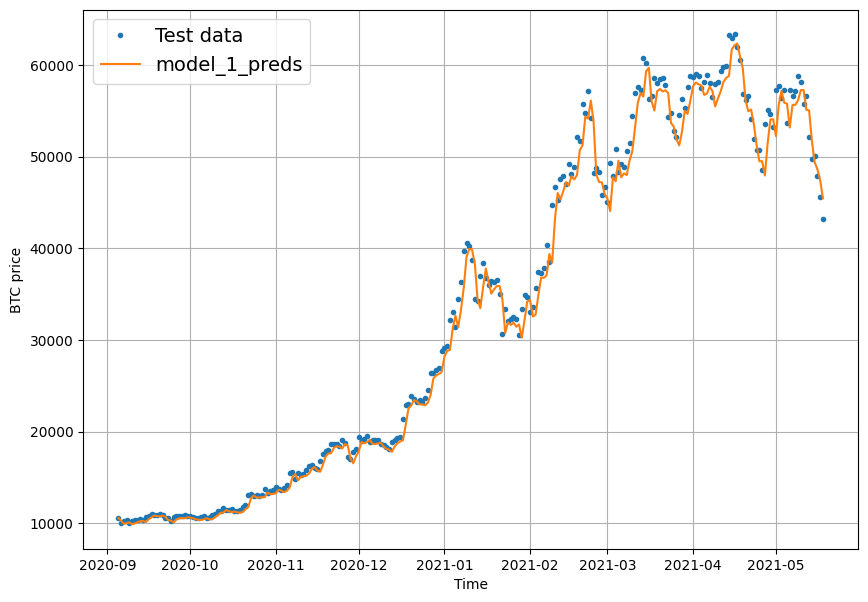

In [40]:
offset= 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0]
                 ,start=offset,label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_1_preds
                 ,start=offset,label="model_1_preds",format="-")


## Model 2: Window size=30, Horizon=1
We will start with our second modelling experiment where the window size=30 and horizon=1

We will use the functions we have created earlier to create our train/test feature and train/test labels


In [41]:
HORIZON=1
WINDOW_SIZE=30

In [42]:
full_windows, full_labels = make_windows(prices,window_size=WINDOW_SIZE
                                         ,horizon=HORIZON)

len(full_windows), len(full_labels)

(2757, 2757)

In [43]:
train_window, train_label, test_window , test_label=make_train_test_split(full_windows
                                                                         ,full_labels
                                                                         ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)


(2205, 2205, 552, 552)

In [44]:
import tensorflow as tf
from tensorflow.keras import layers

# set seed
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128,activation="relu")
    ,layers.Dense(HORIZON,activation="linear")
],name="model_2_Dense")

model_2.compile(loss="mae"
                 ,optimizer=tf.keras.optimizers.Adam()
                 ,metrics=["mae"]
                 )
history_2 = model_2.fit(x=train_window
                        ,y=train_label
                        ,epochs=100
                        ,verbose=1
                        ,validation_data=(test_window,test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_2.name)])





Epoch 1/100
59/69 [========================>.....] - ETA: 0s - loss: 445.1559 - mae: 445.1559

69/69 [==============================] - 2s 12ms/step - loss: 423.8486 - mae: 423.8486 - val_loss: 1494.2836 - val_mae: 1494.2836
Epoch 2/100
69/69 [==============================] - 0s 4ms/step - loss: 278.8606 - mae: 278.8606 - val_loss: 1575.6565 - val_mae: 1575.6565
Epoch 3/100
69/69 [==============================] - ETA: 0s - loss: 224.3992 - mae: 224.3992

69/69 [==============================] - 1s 10ms/step - loss: 224.3992 - mae: 224.3992 - val_loss: 1274.7705 - val_mae: 1274.7705
Epoch 4/100
58/69 [========================>.....] - ETA: 0s - loss: 212.6986 - mae: 212.6986

69/69 [==============================] - 1s 10ms/step - loss: 208.6272 - mae: 208.6272 - val_loss: 983.8549 - val_mae: 983.8549
Epoch 5/100
52/69 [=====================>........] - ETA: 0s - loss: 200.3709 - mae: 200.3709

69/69 [==============================] - 1s 10ms/step - loss: 196.9082 - mae: 196.9082 - val_loss: 920.1408 - val_mae: 920.1408
Epoch 6/100
69/69 [==============================] - 0s 4ms/step - loss: 191.1449 - mae: 191.1449 - val_loss: 1166.8906 - val_mae: 1166.8906
Epoch 7/100
69/69 [==============================] - ETA: 0s - loss: 173.3860 - mae: 173.3860

69/69 [==============================] - 1s 11ms/step - loss: 173.3860 - mae: 173.3860 - val_loss: 845.1827 - val_mae: 845.1827
Epoch 8/100
69/69 [==============================] - 0s 4ms/step - loss: 179.5785 - mae: 179.5785 - val_loss: 876.2278 - val_mae: 876.2278
Epoch 9/100
69/69 [==============================] - 0s 3ms/step - loss: 171.7163 - mae: 171.7163 - val_loss: 899.3888 - val_mae: 899.3888
Epoch 10/100
69/69 [==============================] - 0s 4ms/step - loss: 173.6712 - mae: 173.6712 - val_loss: 1030.4342 - val_mae: 1030.4342
Epoch 11/100
69/69 [==============================] - 0s 4ms/step - loss: 182.7157 - mae: 182.7157 - val_loss: 2023.8059 - val_mae: 2023.8059
Epoch 12/100
69/69 [==============================] - 0s 5ms/step - loss: 177.9825 - mae: 177.9825 - val_loss: 1084.7167 - val_mae: 1084.7167
Epoch 13/100
69/69 [==============================] - ETA: 0s - loss: 176.6446 - mae: 176.6446

69/69 [==============================] - 1s 14ms/step - loss: 176.6446 - mae: 176.6446 - val_loss: 806.7264 - val_mae: 806.7264
Epoch 14/100
69/69 [==============================] - 0s 5ms/step - loss: 165.7341 - mae: 165.7341 - val_loss: 1109.6177 - val_mae: 1109.6177
Epoch 15/100
69/69 [==============================] - 0s 5ms/step - loss: 153.3610 - mae: 153.3610 - val_loss: 1191.8323 - val_mae: 1191.8323
Epoch 16/100
69/69 [==============================] - 0s 5ms/step - loss: 159.7804 - mae: 159.7804 - val_loss: 1026.9835 - val_mae: 1026.9835
Epoch 17/100
69/69 [==============================] - 0s 4ms/step - loss: 165.8900 - mae: 165.8900 - val_loss: 831.6263 - val_mae: 831.6263
Epoch 18/100
69/69 [==============================] - 0s 4ms/step - loss: 152.1694 - mae: 152.1694 - val_loss: 1032.5422 - val_mae: 1032.5422
Epoch 19/100
69/69 [==============================] - 0s 3ms/step - loss: 163.7526 - mae: 163.7526 - val_loss: 943.2602 - val_mae: 943.2602
Epoch 20/100
69/69 [====

69/69 [==============================] - 1s 10ms/step - loss: 174.0245 - mae: 174.0245 - val_loss: 660.6422 - val_mae: 660.6422
Epoch 23/100
69/69 [==============================] - 0s 4ms/step - loss: 159.6307 - mae: 159.6307 - val_loss: 1381.1975 - val_mae: 1381.1975
Epoch 24/100
69/69 [==============================] - 0s 4ms/step - loss: 178.7924 - mae: 178.7924 - val_loss: 1307.4944 - val_mae: 1307.4944
Epoch 25/100
69/69 [==============================] - 0s 4ms/step - loss: 166.2912 - mae: 166.2912 - val_loss: 749.5237 - val_mae: 749.5237
Epoch 26/100
69/69 [==============================] - 0s 3ms/step - loss: 158.5002 - mae: 158.5002 - val_loss: 837.4659 - val_mae: 837.4659
Epoch 27/100
51/69 [=====================>........] - ETA: 0s - loss: 152.6817 - mae: 152.6817

69/69 [==============================] - 1s 10ms/step - loss: 154.1623 - mae: 154.1623 - val_loss: 650.1835 - val_mae: 650.1835
Epoch 28/100
69/69 [==============================] - 0s 3ms/step - loss: 157.5792 - mae: 157.5792 - val_loss: 1031.0817 - val_mae: 1031.0817
Epoch 29/100
60/69 [=========================>....] - ETA: 0s - loss: 131.3700 - mae: 131.3700

69/69 [==============================] - 1s 14ms/step - loss: 133.4531 - mae: 133.4531 - val_loss: 639.4739 - val_mae: 639.4739
Epoch 30/100
69/69 [==============================] - 0s 3ms/step - loss: 144.3623 - mae: 144.3623 - val_loss: 891.0324 - val_mae: 891.0324
Epoch 31/100
69/69 [==============================] - 0s 4ms/step - loss: 136.5397 - mae: 136.5397 - val_loss: 722.1498 - val_mae: 722.1498
Epoch 32/100
58/69 [========================>.....] - ETA: 0s - loss: 138.2396 - mae: 138.2396

69/69 [==============================] - 1s 10ms/step - loss: 134.4981 - mae: 134.4981 - val_loss: 637.2665 - val_mae: 637.2665
Epoch 33/100
69/69 [==============================] - 0s 4ms/step - loss: 124.7154 - mae: 124.7154 - val_loss: 663.8488 - val_mae: 663.8488
Epoch 34/100
69/69 [==============================] - 0s 3ms/step - loss: 160.3088 - mae: 160.3088 - val_loss: 1454.2963 - val_mae: 1454.2963
Epoch 35/100
59/69 [========================>.....] - ETA: 0s - loss: 177.6360 - mae: 177.6360

69/69 [==============================] - 1s 10ms/step - loss: 170.4527 - mae: 170.4527 - val_loss: 612.2373 - val_mae: 612.2373
Epoch 36/100
69/69 [==============================] - 0s 4ms/step - loss: 140.0067 - mae: 140.0067 - val_loss: 628.7796 - val_mae: 628.7796
Epoch 37/100
69/69 [==============================] - 0s 4ms/step - loss: 208.8219 - mae: 208.8219 - val_loss: 850.7152 - val_mae: 850.7152
Epoch 38/100
69/69 [==============================] - 0s 4ms/step - loss: 143.3329 - mae: 143.3329 - val_loss: 617.3625 - val_mae: 617.3625
Epoch 39/100
69/69 [==============================] - 0s 4ms/step - loss: 129.4005 - mae: 129.4005 - val_loss: 798.1188 - val_mae: 798.1188
Epoch 40/100
69/69 [==============================] - 0s 4ms/step - loss: 148.8061 - mae: 148.8061 - val_loss: 811.5228 - val_mae: 811.5228
Epoch 41/100
69/69 [==============================] - 0s 4ms/step - loss: 136.7086 - mae: 136.7086 - val_loss: 663.1403 - val_mae: 663.1403
Epoch 42/100
69/69 [============

69/69 [==============================] - 1s 13ms/step - loss: 148.9216 - mae: 148.9216 - val_loss: 602.0232 - val_mae: 602.0232
Epoch 51/100
69/69 [==============================] - 0s 3ms/step - loss: 122.6281 - mae: 122.6281 - val_loss: 729.2701 - val_mae: 729.2701
Epoch 52/100
69/69 [==============================] - 0s 4ms/step - loss: 132.7607 - mae: 132.7607 - val_loss: 615.4137 - val_mae: 615.4137
Epoch 53/100
69/69 [==============================] - 0s 3ms/step - loss: 134.6071 - mae: 134.6071 - val_loss: 672.9333 - val_mae: 672.9333
Epoch 54/100
69/69 [==============================] - 0s 4ms/step - loss: 144.0987 - mae: 144.0987 - val_loss: 677.7491 - val_mae: 677.7491
Epoch 55/100
69/69 [==============================] - 0s 4ms/step - loss: 125.6039 - mae: 125.6039 - val_loss: 612.6928 - val_mae: 612.6928
Epoch 56/100
69/69 [==============================] - 0s 4ms/step - loss: 153.3016 - mae: 153.3016 - val_loss: 642.6088 - val_mae: 642.6088
Epoch 57/100
69/69 [============

69/69 [==============================] - 1s 18ms/step - loss: 120.6862 - mae: 120.6862 - val_loss: 599.6606 - val_mae: 599.6606
Epoch 64/100
69/69 [==============================] - 0s 4ms/step - loss: 133.4411 - mae: 133.4411 - val_loss: 860.0747 - val_mae: 860.0747
Epoch 65/100
69/69 [==============================] - 0s 4ms/step - loss: 141.4267 - mae: 141.4267 - val_loss: 778.9020 - val_mae: 778.9020
Epoch 66/100
69/69 [==============================] - 0s 3ms/step - loss: 154.5925 - mae: 154.5925 - val_loss: 1063.6385 - val_mae: 1063.6385
Epoch 67/100
69/69 [==============================] - 0s 4ms/step - loss: 129.8449 - mae: 129.8449 - val_loss: 747.9236 - val_mae: 747.9236
Epoch 68/100
69/69 [==============================] - 0s 4ms/step - loss: 133.8093 - mae: 133.8093 - val_loss: 1051.2872 - val_mae: 1051.2872
Epoch 69/100
69/69 [==============================] - 0s 3ms/step - loss: 155.4720 - mae: 155.4720 - val_loss: 704.3629 - val_mae: 704.3629
Epoch 70/100
69/69 [========

69/69 [==============================] - 1s 10ms/step - loss: 122.1019 - mae: 122.1019 - val_loss: 583.7012 - val_mae: 583.7012
Epoch 88/100
69/69 [==============================] - 0s 3ms/step - loss: 123.8650 - mae: 123.8650 - val_loss: 1254.3960 - val_mae: 1254.3960
Epoch 89/100
69/69 [==============================] - 0s 4ms/step - loss: 132.3135 - mae: 132.3135 - val_loss: 967.2007 - val_mae: 967.2007
Epoch 90/100
69/69 [==============================] - 0s 4ms/step - loss: 124.0941 - mae: 124.0941 - val_loss: 826.2977 - val_mae: 826.2977
Epoch 91/100
69/69 [==============================] - 0s 4ms/step - loss: 120.6179 - mae: 120.6179 - val_loss: 803.0301 - val_mae: 803.0301
Epoch 92/100
69/69 [==============================] - 0s 4ms/step - loss: 129.1586 - mae: 129.1586 - val_loss: 627.6810 - val_mae: 627.6810
Epoch 93/100
69/69 [==============================] - 0s 4ms/step - loss: 125.0297 - mae: 125.0297 - val_loss: 601.3206 - val_mae: 601.3206
Epoch 94/100
69/69 [==========

In [45]:
# Evaluate model
model_2.evaluate(test_window,test_label)

18/18 [==============================] - 0s 3ms/step - loss: 634.0131 - mae: 634.0131


[634.0131225585938, 634.0131225585938]

In [46]:
model_2_preds = make_preds(model_2,test_window)
len(model_2_preds),model_2_preds[:10]

18/18 [==============================] - 0s 1ms/step


(552,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8697.808 , 8712.291 , 8569.951 , 8406.633 , 8213.157 , 8256.99  ,
        8085.1177, 8012.28  , 8013.013 , 7598.851 ], dtype=float32)>)

In [47]:
model_2_results = evaluate_pred(y_true=tf.squeeze(test_label)
                                ,y_pred=model_2_preds)
model_2_results

{'mae': 634.01306,
 'mse': 1309805.1,
 'rmse': 1144.4672,
 'mape': 2.9249723,
 'mase': 1.1082611}

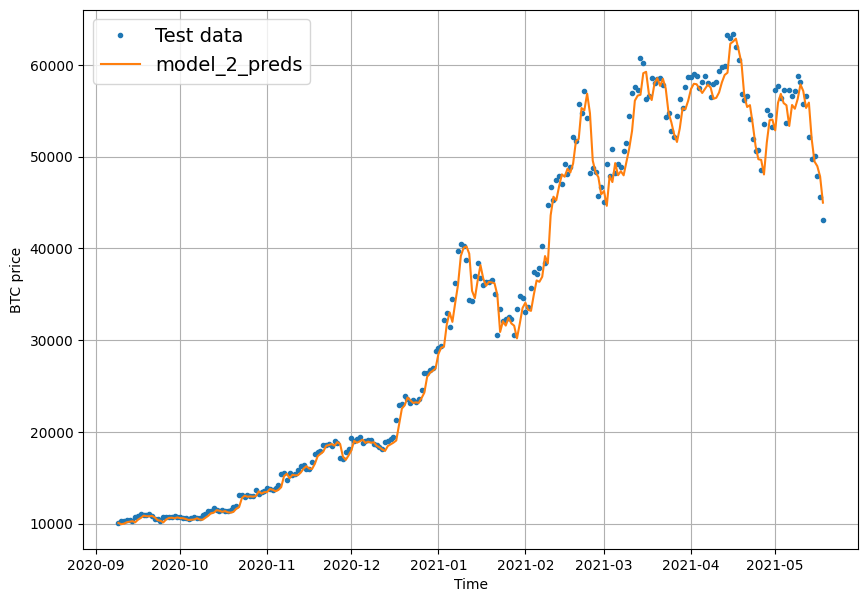

In [48]:
## Lets plot the predictions
offset=300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_window):],values=test_label[:,0]
                 ,start=offset,label="Test data")
plot_time_series(timesteps=X_test[-len(test_window):],values=model_2_preds
                 ,start=offset,label="model_2_preds",format="-")

## Model 3: Window size=30, Horizon=7

In [49]:
WINDOW_SIZE=30
HORIZON=7
full_window, full_label = make_windows(prices, window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_window), len(full_label)

(2751, 2751)

In [50]:
train_window, train_label, test_window, test_label = make_train_test_split(windows=full_window, labels=full_label
                                                                           ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)

(2200, 2200, 551, 551)

In [51]:
import tensorflow as tf
from tensorflow.keras import layers
# set random seed
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu")
    ,layers.Dense(HORIZON,activation="linear")
],name="model_3_dense")

model_3.compile(loss="mae"
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"])

history_3 = model_3.fit(x=train_window
                        ,y=train_label
                        ,epochs=100
                        ,verbose=1
                        ,validation_data=(test_window,test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
64/69 [==========================>...] - ETA: 0s - loss: 772.6198 - mae: 772.6198

69/69 [==============================] - 2s 17ms/step - loss: 743.8559 - mae: 743.8559 - val_loss: 1883.5452 - val_mae: 1883.5452
Epoch 2/100
66/69 [===========================>..] - ETA: 0s - loss: 331.1253 - mae: 331.1253

69/69 [==============================] - 1s 15ms/step - loss: 329.8561 - mae: 329.8561 - val_loss: 1662.0775 - val_mae: 1662.0775
Epoch 3/100
58/69 [========================>.....] - ETA: 0s - loss: 299.9583 - mae: 299.9583

69/69 [==============================] - 1s 10ms/step - loss: 300.4471 - mae: 300.4471 - val_loss: 1574.2244 - val_mae: 1574.2244
Epoch 4/100
57/69 [=======================>......] - ETA: 0s - loss: 292.1471 - mae: 292.1471

69/69 [==============================] - 1s 10ms/step - loss: 288.7115 - mae: 288.7115 - val_loss: 1499.3739 - val_mae: 1499.3739
Epoch 5/100
69/69 [==============================] - 0s 4ms/step - loss: 273.5105 - mae: 273.5105 - val_loss: 1778.4250 - val_mae: 1778.4250
Epoch 6/100
69/69 [==============================] - 0s 4ms/step - loss: 269.8494 - mae: 269.8494 - val_loss: 1641.4822 - val_mae: 1641.4822
Epoch 7/100
59/69 [========================>.....] - ETA: 0s - loss: 279.1927 - mae: 279.1927

69/69 [==============================] - 1s 10ms/step - loss: 272.9425 - mae: 272.9425 - val_loss: 1393.0469 - val_mae: 1393.0469
Epoch 8/100
69/69 [==============================] - 0s 3ms/step - loss: 271.9364 - mae: 271.9364 - val_loss: 1447.4957 - val_mae: 1447.4957
Epoch 9/100
56/69 [=======================>......] - ETA: 0s - loss: 260.9108 - mae: 260.9108

69/69 [==============================] - 1s 10ms/step - loss: 259.7903 - mae: 259.7903 - val_loss: 1370.0909 - val_mae: 1370.0909
Epoch 10/100
69/69 [==============================] - 0s 4ms/step - loss: 262.1076 - mae: 262.1076 - val_loss: 1431.9198 - val_mae: 1431.9198
Epoch 11/100
69/69 [==============================] - 0s 4ms/step - loss: 252.8826 - mae: 252.8826 - val_loss: 1420.3988 - val_mae: 1420.3988
Epoch 12/100
69/69 [==============================] - 0s 4ms/step - loss: 256.5978 - mae: 256.5978 - val_loss: 1454.6118 - val_mae: 1454.6118
Epoch 13/100
69/69 [==============================] - 0s 4ms/step - loss: 253.6565 - mae: 253.6565 - val_loss: 1711.4354 - val_mae: 1711.4354
Epoch 14/100
69/69 [==============================] - 0s 4ms/step - loss: 255.4153 - mae: 255.4153 - val_loss: 1412.9821 - val_mae: 1412.9821
Epoch 15/100
69/69 [==============================] - 0s 3ms/step - loss: 249.9859 - mae: 249.9859 - val_loss: 1586.0344 - val_mae: 1586.0344
Epoch 16/100
69/69

69/69 [==============================] - 1s 10ms/step - loss: 244.5867 - mae: 244.5867 - val_loss: 1359.5876 - val_mae: 1359.5876
Epoch 21/100
60/69 [=========================>....] - ETA: 0s - loss: 241.2392 - mae: 241.2392

69/69 [==============================] - 1s 9ms/step - loss: 242.4239 - mae: 242.4239 - val_loss: 1312.2157 - val_mae: 1312.2157
Epoch 22/100
69/69 [==============================] - 0s 3ms/step - loss: 243.1812 - mae: 243.1812 - val_loss: 1560.1699 - val_mae: 1560.1699
Epoch 23/100
69/69 [==============================] - 0s 4ms/step - loss: 245.7632 - mae: 245.7632 - val_loss: 1314.6078 - val_mae: 1314.6078
Epoch 24/100
59/69 [========================>.....] - ETA: 0s - loss: 248.2387 - mae: 248.2387

69/69 [==============================] - 1s 14ms/step - loss: 243.8179 - mae: 243.8179 - val_loss: 1302.7651 - val_mae: 1302.7651
Epoch 25/100
69/69 [==============================] - 0s 4ms/step - loss: 237.1894 - mae: 237.1894 - val_loss: 1451.3645 - val_mae: 1451.3645
Epoch 26/100
69/69 [==============================] - 0s 3ms/step - loss: 237.3368 - mae: 237.3368 - val_loss: 1347.7156 - val_mae: 1347.7156
Epoch 27/100
69/69 [==============================] - 0s 4ms/step - loss: 245.2338 - mae: 245.2338 - val_loss: 1413.0417 - val_mae: 1413.0417
Epoch 28/100
58/69 [========================>.....] - ETA: 0s - loss: 247.4073 - mae: 247.4073

69/69 [==============================] - 1s 13ms/step - loss: 243.2905 - mae: 243.2905 - val_loss: 1293.2947 - val_mae: 1293.2947
Epoch 29/100
66/69 [===========================>..] - ETA: 0s - loss: 233.0294 - mae: 233.0294

69/69 [==============================] - 1s 15ms/step - loss: 233.4357 - mae: 233.4357 - val_loss: 1274.7781 - val_mae: 1274.7781
Epoch 30/100
69/69 [==============================] - 0s 5ms/step - loss: 238.4858 - mae: 238.4858 - val_loss: 1508.9183 - val_mae: 1508.9183
Epoch 31/100
69/69 [==============================] - 0s 5ms/step - loss: 235.8986 - mae: 235.8986 - val_loss: 1331.5992 - val_mae: 1331.5992
Epoch 32/100
69/69 [==============================] - 0s 3ms/step - loss: 241.1038 - mae: 241.1038 - val_loss: 1315.1036 - val_mae: 1315.1036
Epoch 33/100
68/69 [============================>.] - ETA: 0s - loss: 237.2258 - mae: 237.2258

69/69 [==============================] - 1s 10ms/step - loss: 236.1354 - mae: 236.1354 - val_loss: 1274.0161 - val_mae: 1274.0161
Epoch 34/100
69/69 [==============================] - 0s 4ms/step - loss: 233.0959 - mae: 233.0959 - val_loss: 1557.3502 - val_mae: 1557.3502
Epoch 35/100
55/69 [======================>.......] - ETA: 0s - loss: 237.3243 - mae: 237.3243

69/69 [==============================] - 1s 10ms/step - loss: 232.0848 - mae: 232.0848 - val_loss: 1252.6290 - val_mae: 1252.6290
Epoch 36/100
69/69 [==============================] - 0s 3ms/step - loss: 241.5671 - mae: 241.5671 - val_loss: 1254.5829 - val_mae: 1254.5829
Epoch 37/100
69/69 [==============================] - 0s 4ms/step - loss: 238.7305 - mae: 238.7305 - val_loss: 1282.4253 - val_mae: 1282.4253
Epoch 38/100
69/69 [==============================] - 0s 4ms/step - loss: 230.2573 - mae: 230.2573 - val_loss: 1344.3372 - val_mae: 1344.3372
Epoch 39/100
69/69 [==============================] - 0s 3ms/step - loss: 256.4080 - mae: 256.4080 - val_loss: 1289.8755 - val_mae: 1289.8755
Epoch 40/100
69/69 [==============================] - 0s 4ms/step - loss: 239.9809 - mae: 239.9809 - val_loss: 1313.7544 - val_mae: 1313.7544
Epoch 41/100
52/69 [=====================>........] - ETA: 0s - loss: 241.7284 - mae: 241.7284

69/69 [==============================] - 1s 10ms/step - loss: 239.4847 - mae: 239.4847 - val_loss: 1236.0220 - val_mae: 1236.0220
Epoch 42/100
69/69 [==============================] - 0s 3ms/step - loss: 241.4533 - mae: 241.4533 - val_loss: 1686.9934 - val_mae: 1686.9934
Epoch 43/100
69/69 [==============================] - 0s 4ms/step - loss: 244.6310 - mae: 244.6310 - val_loss: 1263.4486 - val_mae: 1263.4486
Epoch 44/100
69/69 [==============================] - 0s 4ms/step - loss: 234.5083 - mae: 234.5083 - val_loss: 1912.5068 - val_mae: 1912.5068
Epoch 45/100
69/69 [==============================] - 0s 4ms/step - loss: 243.3023 - mae: 243.3023 - val_loss: 1321.5924 - val_mae: 1321.5924
Epoch 46/100
69/69 [==============================] - 0s 4ms/step - loss: 236.4634 - mae: 236.4634 - val_loss: 1408.1840 - val_mae: 1408.1840
Epoch 47/100
69/69 [==============================] - 0s 4ms/step - loss: 242.9262 - mae: 242.9262 - val_loss: 1756.3514 - val_mae: 1756.3514
Epoch 48/100
69/69

69/69 [==============================] - 1s 10ms/step - loss: 229.7576 - mae: 229.7576 - val_loss: 1213.5435 - val_mae: 1213.5435
Epoch 58/100
69/69 [==============================] - 0s 3ms/step - loss: 229.0619 - mae: 229.0619 - val_loss: 1410.3141 - val_mae: 1410.3141
Epoch 59/100
69/69 [==============================] - 0s 4ms/step - loss: 234.7133 - mae: 234.7133 - val_loss: 1313.2419 - val_mae: 1313.2419
Epoch 60/100
69/69 [==============================] - 0s 4ms/step - loss: 232.1592 - mae: 232.1592 - val_loss: 1274.4647 - val_mae: 1274.4647
Epoch 61/100
69/69 [==============================] - 0s 4ms/step - loss: 222.4841 - mae: 222.4841 - val_loss: 1227.6515 - val_mae: 1227.6515
Epoch 62/100
69/69 [==============================] - 0s 5ms/step - loss: 222.6774 - mae: 222.6774 - val_loss: 1287.9882 - val_mae: 1287.9882
Epoch 63/100
69/69 [==============================] - 0s 5ms/step - loss: 229.8246 - mae: 229.8246 - val_loss: 1422.6123 - val_mae: 1422.6123
Epoch 64/100
69/69

69/69 [==============================] - 1s 10ms/step - loss: 220.6815 - mae: 220.6815 - val_loss: 1202.5950 - val_mae: 1202.5950
Epoch 93/100
69/69 [==============================] - 0s 3ms/step - loss: 226.0922 - mae: 226.0922 - val_loss: 1729.4728 - val_mae: 1729.4728
Epoch 94/100
69/69 [==============================] - 0s 3ms/step - loss: 237.9921 - mae: 237.9921 - val_loss: 1511.7036 - val_mae: 1511.7036
Epoch 95/100
69/69 [==============================] - 0s 4ms/step - loss: 228.9186 - mae: 228.9186 - val_loss: 1227.8174 - val_mae: 1227.8174
Epoch 96/100
69/69 [==============================] - 0s 3ms/step - loss: 218.6979 - mae: 218.6979 - val_loss: 1236.9867 - val_mae: 1236.9867
Epoch 97/100
69/69 [==============================] - 0s 4ms/step - loss: 220.6133 - mae: 220.6133 - val_loss: 1266.8213 - val_mae: 1266.8213
Epoch 98/100
69/69 [==============================] - 0s 4ms/step - loss: 222.8676 - mae: 222.8676 - val_loss: 1257.9640 - val_mae: 1257.9640
Epoch 99/100
69/69

In [52]:
model_3.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 1375.9609 - mae: 1375.9609


[1375.9609375, 1375.9609375]

In [53]:
model_3_preds = make_preds(model_3,test_window)
len(model_3_preds), model_3_preds[:10]

18/18 [==============================] - 0s 2ms/step


(551,
 <tf.Tensor: shape=(10, 7), dtype=float32, numpy=
 array([[9092.079 , 9080.827 , 9022.184 , 9315.592 , 9180.956 , 9350.212 ,
         9186.933 ],
        [8605.27  , 8733.383 , 8621.523 , 9000.915 , 8831.965 , 9163.045 ,
         8845.    ],
        [8412.644 , 8525.343 , 8465.412 , 8877.059 , 8648.747 , 8996.982 ,
         8626.996 ],
        [8666.46  , 8864.506 , 8788.812 , 9038.298 , 8943.724 , 9191.488 ,
         8802.885 ],
        [8527.836 , 8792.442 , 8638.205 , 8922.562 , 8850.479 , 9007.714 ,
         8631.734 ],
        [8523.734 , 8709.737 , 8514.214 , 8844.539 , 8585.52  , 8723.818 ,
         8436.141 ],
        [8556.417 , 8604.675 , 8561.225 , 8775.789 , 8552.4795, 8601.43  ,
         8263.617 ],
        [8439.315 , 8475.086 , 8371.733 , 8583.713 , 8317.957 , 8468.481 ,
         8111.506 ],
        [8224.679 , 8274.522 , 8084.9004, 8207.76  , 8174.2207, 8338.42  ,
         7969.5186],
        [8018.587 , 8123.8955, 7959.141 , 8125.0244, 8041.017 , 8377.129 ,
     

In [54]:
model_3_results = evaluate_pred(y_true=tf.squeeze(test_label),
                                y_pred=model_3_preds)
model_3_results

{'mae': array([ 399.18332 ,  257.64062 ,  277.15012 ,  285.73688 ,  284.8831  ,
         221.60637 ,  221.91225 ,  243.21965 ,  321.4345  ,  407.70578 ,
         516.7841  ,  581.9501  ,  641.9001  ,  716.34174 ,  346.35785 ,
         261.2959  ,  310.5782  ,  574.46405 ,  501.7899  ,  519.75775 ,
         224.07707 ,  238.59828 ,  220.95383 ,  152.44887 ,  177.06627 ,
         336.52084 ,  319.75153 ,  459.6868  ,  285.7085  ,  208.3425  ,
         134.19377 ,  110.32631 ,  114.536064,  231.95969 ,  310.1504  ,
         256.03098 ,  235.02127 ,  253.88957 ,  323.0394  ,  405.93268 ,
         841.0911  ,  265.88998 ,  225.9949  ,  289.72488 ,  141.65276 ,
         166.45369 ,  217.72105 ,  212.30978 ,  283.86606 ,  239.15723 ,
         349.44547 ,  175.93457 ,  178.88582 ,  249.61014 ,  427.12277 ,
         577.708   ,  852.7201  ,  765.201   ,  671.48236 ,  806.0622  ,
         534.74414 ,  323.4987  ,  294.2202  ,  619.69415 ,  653.2486  ,
         642.5125  ,  650.0294  ,  749.2895 

### Make our evaluation function work for larger horizons
We need to update `evaluate_preds` function to work with multiple shapes of data

In [55]:
def evaluate_preds(y_true,y_pred):
  """
   Ensure float32 for metric calculation
  """
  y_true= tf.cast(y_true,dtype=tf.float32)
  y_pred= tf.cast(y_pred,dtype=tf.float32)

  # Calculate the various metrics
  mae= tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mape= tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mse= tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse= tf.sqrt(mse)
  mase= mean_absolute_scaled_error(y_true,y_pred)

  ## Account for different size of matrices (for longer horizons reduce to single number)
  if mae.ndim > 0:
    mae= tf.reduce_mean(mae)
    mape= tf.reduce_mean(mape)
    rmse= tf.reduce_mean(rmse)
    mase= tf.reduce_mean(mase)
    mse= tf.reduce_mean(mse)

  return {
       "mse":mse.numpy()
      ,"rmse":rmse.numpy()
      ,"mase":mase.numpy()
      ,"mape":mape.numpy()
      ,"mae":mae.numpy()
  }

In [56]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_label),
                                 y_pred=model_3_preds)
model_3_results

{'mse': 5896325.5,
 'rmse': 1555.9839,
 'mase': 2.4484458,
 'mape': 6.177676,
 'mae': 1375.961}

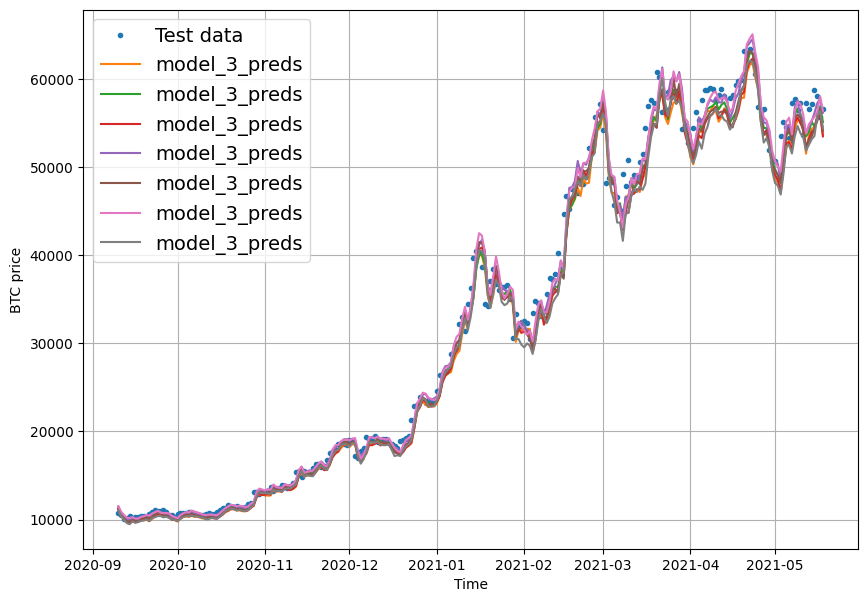

In [57]:
## Visualize the predictions
offset= 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps= X_test[-len(test_window):]
                 ,values= test_label[:,0]
                 ,start= offset
                 ,label= "Test data")
plot_time_series(timesteps= X_test[-len(test_window):]
                 ,values= model_3_preds
                 ,start= offset
                 ,label= "model_3_preds"
                 ,format= "-")

We can aggregate the model prediction

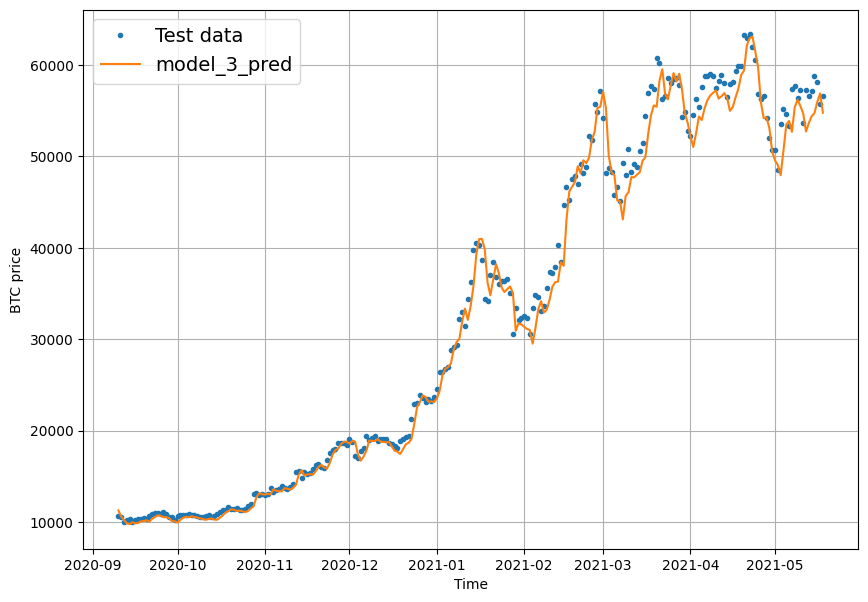

In [58]:
offset= 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_window):]
                 ,values=test_label[:,0]
                 ,start= offset
                 ,label= "Test data")
plot_time_series(timesteps=X_test[-len(test_window):]
                 ,values=tf.reduce_mean(model_3_preds,axis=1)
                 ,start= offset
                 ,label="model_3_pred"
                 ,format="-")

## Model 4: Conv1D
Our next modelling experiment.
This time we will use a Conv1D model. Conv1D can be used for a seq2seq (sequence to sequence) problems.

In our case, the input is the sequence of previous 7 days input and the output is price of bitcoin the following day. Since there are more than 1 input these kind of seq2seq problems are termed as many-to-one problem

In [59]:
HORIZON= 1
WINDOW_SIZE= 7


In [60]:
## Create windowed dataset
full_window,full_label= make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_window), len(full_label)

(2780, 2780)

In [61]:
## create train test split
train_window, train_label, test_window, test_label = make_train_test_split(windows=full_window
                                                                           ,labels=full_label
                                                                           ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)

(2224, 2224, 556, 556)

The Conv1D in Tensorflow takes an input of :(`batch_size, timesteps,input_dim`)
In our case, the `batch_size` (defaults = 32) is handled for us but we need to prepare other inputs.
* `timesteps= WINDOW_SIZE` - the timeestep is also
referred to as `features`. Our `features` are the previous `WINDOW_SIZE` of bitcoin prices.
* `input_dim=HORIZON` our model views `WINDOW_SIZE` worth of data to predict `HORIZON`

In [62]:
# Check the shape of data samples
train_window[0].shape

(7,)

In [63]:
x= tf.constant(train_window[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))
print(f" Original Shape : {x.shape}")
print(f" Expanded Shape: {expand_dims_layer(x).shape}")
print(f" Original values with expanded shape: \n {expand_dims_layer(x)}")
print(f" Type after expanded dim: {type(expand_dims_layer(x))}")

 Original Shape : (7,)
 Expanded Shape: (7, 1)
 Original values with expanded shape: 
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]
 Type after expanded dim: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [64]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,axis=1))
    ,layers.Conv1D(filters=128,kernel_size=5
                   ,padding="causal",activation="relu")
    ,layers.Dense(HORIZON,activation="linear")
],name="model_4_Conv1D")

model_4.compile(loss="mae"
                ,optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

history_4 = model_4.fit(x=train_window
                        ,y=train_label
                        ,epochs=100
                        ,batch_size=32
                        ,validation_data=(test_window,test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_4.name)])


Epoch 1/100
70/70 [==============================] - ETA: 0s - loss: 544.3008 - mae: 544.3008

70/70 [==============================] - 7s 21ms/step - loss: 544.3008 - mae: 544.3008 - val_loss: 1076.0940 - val_mae: 1076.0940
Epoch 2/100
60/70 [========================>.....] - ETA: 0s - loss: 186.3093 - mae: 186.3093

70/70 [==============================] - 1s 19ms/step - loss: 184.6491 - mae: 184.6491 - val_loss: 1049.2444 - val_mae: 1049.2444
Epoch 3/100
65/70 [==========================>...] - ETA: 0s - loss: 182.4569 - mae: 182.4569

70/70 [==============================] - 1s 13ms/step - loss: 179.7316 - mae: 179.7316 - val_loss: 1032.0870 - val_mae: 1032.0870
Epoch 4/100
62/70 [=========================>....] - ETA: 0s - loss: 172.3180 - mae: 172.3180

70/70 [==============================] - 1s 13ms/step - loss: 170.3430 - mae: 170.3430 - val_loss: 864.7631 - val_mae: 864.7631
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 159.7817 - mae: 159.7817 - val_loss: 980.0943 - val_mae: 980.0943
Epoch 6/100
65/70 [==========================>...] - ETA: 0s - loss: 144.3413 - mae: 144.3413

70/70 [==============================] - 1s 18ms/step - loss: 145.5533 - mae: 145.5533 - val_loss: 771.3528 - val_mae: 771.3528
Epoch 7/100
70/70 [==============================] - 0s 4ms/step - loss: 144.8070 - mae: 144.8070 - val_loss: 831.7369 - val_mae: 831.7369
Epoch 8/100
67/70 [===========================>..] - ETA: 0s - loss: 145.6710 - mae: 145.6710

70/70 [==============================] - 1s 13ms/step - loss: 144.5362 - mae: 144.5362 - val_loss: 745.5697 - val_mae: 745.5697
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 142.0315 - mae: 142.0315 - val_loss: 1025.5646 - val_mae: 1025.5646
Epoch 10/100
66/70 [===========================>..] - ETA: 0s - loss: 145.8857 - mae: 145.8857

70/70 [==============================] - 1s 13ms/step - loss: 145.7893 - mae: 145.7893 - val_loss: 735.3966 - val_mae: 735.3966
Epoch 11/100
70/70 [==============================] - 0s 4ms/step - loss: 132.3945 - mae: 132.3945 - val_loss: 876.3164 - val_mae: 876.3164
Epoch 12/100
54/70 [======================>.......] - ETA: 0s - loss: 122.4903 - mae: 122.4903

70/70 [==============================] - 1s 13ms/step - loss: 124.9378 - mae: 124.9378 - val_loss: 704.6521 - val_mae: 704.6521
Epoch 13/100
70/70 [==============================] - 0s 4ms/step - loss: 123.4775 - mae: 123.4775 - val_loss: 712.6924 - val_mae: 712.6924
Epoch 14/100
70/70 [==============================] - 0s 4ms/step - loss: 133.4205 - mae: 133.4205 - val_loss: 1164.5275 - val_mae: 1164.5275
Epoch 15/100
67/70 [===========================>..] - ETA: 0s - loss: 131.5671 - mae: 131.5671

70/70 [==============================] - 1s 13ms/step - loss: 130.8699 - mae: 130.8699 - val_loss: 641.2070 - val_mae: 641.2070
Epoch 16/100
70/70 [==============================] - 0s 4ms/step - loss: 120.1852 - mae: 120.1852 - val_loss: 644.4786 - val_mae: 644.4786
Epoch 17/100
65/70 [==========================>...] - ETA: 0s - loss: 118.2043 - mae: 118.2043

70/70 [==============================] - 1s 13ms/step - loss: 119.8335 - mae: 119.8335 - val_loss: 610.2891 - val_mae: 610.2891
Epoch 18/100
70/70 [==============================] - 0s 5ms/step - loss: 125.4434 - mae: 125.4434 - val_loss: 635.8159 - val_mae: 635.8159
Epoch 19/100
70/70 [==============================] - 0s 6ms/step - loss: 120.8898 - mae: 120.8898 - val_loss: 610.9021 - val_mae: 610.9021
Epoch 20/100
70/70 [==============================] - 0s 6ms/step - loss: 116.9703 - mae: 116.9703 - val_loss: 688.6034 - val_mae: 688.6034
Epoch 21/100
59/70 [========================>.....] - ETA: 0s - loss: 123.6013 - mae: 123.6013

70/70 [==============================] - 1s 18ms/step - loss: 123.2989 - mae: 123.2989 - val_loss: 598.9861 - val_mae: 598.9861
Epoch 22/100
70/70 [==============================] - 0s 4ms/step - loss: 120.3710 - mae: 120.3710 - val_loss: 642.0093 - val_mae: 642.0093
Epoch 23/100
70/70 [==============================] - 0s 4ms/step - loss: 127.5217 - mae: 127.5217 - val_loss: 731.7346 - val_mae: 731.7346
Epoch 24/100
65/70 [==========================>...] - ETA: 0s - loss: 122.5237 - mae: 122.5237

70/70 [==============================] - 1s 13ms/step - loss: 120.5481 - mae: 120.5481 - val_loss: 589.7714 - val_mae: 589.7714
Epoch 25/100
63/70 [==========================>...] - ETA: 0s - loss: 125.5528 - mae: 125.5528

70/70 [==============================] - 1s 13ms/step - loss: 122.8476 - mae: 122.8476 - val_loss: 587.6857 - val_mae: 587.6857
Epoch 26/100
70/70 [==============================] - 0s 5ms/step - loss: 126.7180 - mae: 126.7180 - val_loss: 592.6880 - val_mae: 592.6880
Epoch 27/100
70/70 [==============================] - 0s 4ms/step - loss: 115.3825 - mae: 115.3825 - val_loss: 765.7358 - val_mae: 765.7358
Epoch 28/100
70/70 [==============================] - 0s 4ms/step - loss: 116.5944 - mae: 116.5944 - val_loss: 606.4507 - val_mae: 606.4507
Epoch 29/100
70/70 [==============================] - 0s 5ms/step - loss: 116.6020 - mae: 116.6020 - val_loss: 593.7092 - val_mae: 593.7092
Epoch 30/100
70/70 [==============================] - 0s 4ms/step - loss: 114.3203 - mae: 114.3203 - val_loss: 600.6965 - val_mae: 600.6965
Epoch 31/100
70/70 [==============================] - 0s 4ms/step - loss: 114.1478 - mae: 114.1478 - val_loss: 713.4081 - val_mae: 713.4081
Epoch 32/100
65/70 [============

70/70 [==============================] - 1s 13ms/step - loss: 115.4007 - mae: 115.4007 - val_loss: 580.4081 - val_mae: 580.4081
Epoch 33/100
70/70 [==============================] - 0s 4ms/step - loss: 117.0412 - mae: 117.0412 - val_loss: 679.1119 - val_mae: 679.1119
Epoch 34/100
70/70 [==============================] - 0s 5ms/step - loss: 120.5761 - mae: 120.5761 - val_loss: 595.5486 - val_mae: 595.5486
Epoch 35/100
68/70 [============================>.] - ETA: 0s - loss: 109.7903 - mae: 109.7903

70/70 [==============================] - 1s 13ms/step - loss: 109.3998 - mae: 109.3998 - val_loss: 575.0822 - val_mae: 575.0822
Epoch 36/100
70/70 [==============================] - 0s 4ms/step - loss: 117.6361 - mae: 117.6361 - val_loss: 722.3827 - val_mae: 722.3827
Epoch 37/100
70/70 [==============================] - 0s 4ms/step - loss: 112.8540 - mae: 112.8540 - val_loss: 587.9744 - val_mae: 587.9744
Epoch 38/100
70/70 [==============================] - 0s 5ms/step - loss: 130.8501 - mae: 130.8501 - val_loss: 997.3917 - val_mae: 997.3917
Epoch 39/100
70/70 [==============================] - 0s 4ms/step - loss: 115.0602 - mae: 115.0602 - val_loss: 684.2651 - val_mae: 684.2651
Epoch 40/100
70/70 [==============================] - 0s 4ms/step - loss: 115.8742 - mae: 115.8742 - val_loss: 717.9296 - val_mae: 717.9296
Epoch 41/100
70/70 [==============================] - 0s 4ms/step - loss: 112.2681 - mae: 112.2681 - val_loss: 801.6157 - val_mae: 801.6157
Epoch 42/100
70/70 [============

70/70 [==============================] - 1s 13ms/step - loss: 112.9799 - mae: 112.9799 - val_loss: 568.2032 - val_mae: 568.2032
Epoch 55/100
66/70 [===========================>..] - ETA: 0s - loss: 111.8364 - mae: 111.8364

70/70 [==============================] - 1s 18ms/step - loss: 109.8409 - mae: 109.8409 - val_loss: 567.5195 - val_mae: 567.5195
Epoch 56/100
64/70 [==========================>...] - ETA: 0s - loss: 109.0671 - mae: 109.0671

70/70 [==============================] - 1s 13ms/step - loss: 107.9482 - mae: 107.9482 - val_loss: 566.2661 - val_mae: 566.2661
Epoch 57/100
70/70 [==============================] - 0s 4ms/step - loss: 109.7055 - mae: 109.7055 - val_loss: 596.4394 - val_mae: 596.4394
Epoch 58/100
70/70 [==============================] - 0s 4ms/step - loss: 110.0909 - mae: 110.0909 - val_loss: 583.2535 - val_mae: 583.2535
Epoch 59/100
70/70 [==============================] - 0s 5ms/step - loss: 112.4583 - mae: 112.4583 - val_loss: 572.2051 - val_mae: 572.2051
Epoch 60/100
70/70 [==============================] - 0s 4ms/step - loss: 109.4642 - mae: 109.4642 - val_loss: 581.5756 - val_mae: 581.5756
Epoch 61/100
70/70 [==============================] - 0s 4ms/step - loss: 108.8525 - mae: 108.8525 - val_loss: 598.4522 - val_mae: 598.4522
Epoch 62/100
70/70 [==============================] - 0s 5ms/step - loss: 109.1981 - mae: 109.1981 - val_loss: 636.3805 - val_mae: 636.3805
Epoch 63/100
70/70 [============

In [65]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Load the best model
saved_conv1d_model = tf.keras.models.load_model("/content/model_experiment/model_4_Conv1D")
saved_conv1d_model.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 566.2661 - mae: 566.2661


[566.26611328125, 566.26611328125]

In [67]:
model_4_preds = make_preds(saved_conv1d_model,test_window)
model_4_preds[:10],len(model_4_preds)

18/18 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8869.302, 8787.872, 9029.181, 8793.793, 8743.754, 8744.093,
        8681.97 , 8530.429, 8467.5  , 8526.711], dtype=float32)>,
 556)

In [68]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_label),
                                 y_pred=model_4_preds)
model_4_results

{'mse': 1164680.2,
 'rmse': 1079.2035,
 'mase': 0.99477285,
 'mape': 2.5275211,
 'mae': 566.2662}

## Model 5: RNN(LSTM)

In [69]:
import tensorflow as tf
from tensorflow.keras import layers

# set seed
tf.random.set_seed(42)

## Using the functional API
inputs= layers.Input(shape=(WINDOW_SIZE))
x= layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)
x= layers.LSTM(128,activation="relu")(x)
outputs= layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs= inputs, outputs= outputs
                         ,name="model_5_LSTM")

model_5.compile(loss="mae"
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"])

history_5 = model_5.fit(x=train_window,
                        y=train_label
                        ,verbose=0
                        ,epochs=100
                        ,batch_size=32
                        ,validation_data=(test_window, test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [70]:
# Load the best saved model
saved_lstm_model = tf.keras.models.load_model("/content/model_experiment/model_5_LSTM")
saved_lstm_model.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 566.1912 - mae: 566.1912


[566.1912231445312, 566.1912231445312]

In [71]:
model_5_preds= make_preds(saved_lstm_model,test_window)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8876.203, 8784.714, 9030.373, 8787.653, 8744.29 , 8745.213,
       8702.728, 8524.59 , 8470.256, 8534.89 ], dtype=float32)>

In [72]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_label),
                                 y_pred=model_5_preds)
model_5_results

{'mse': 1165379.2,
 'rmse': 1079.5273,
 'mase': 0.9946412,
 'mape': 2.5367618,
 'mae': 566.1912}

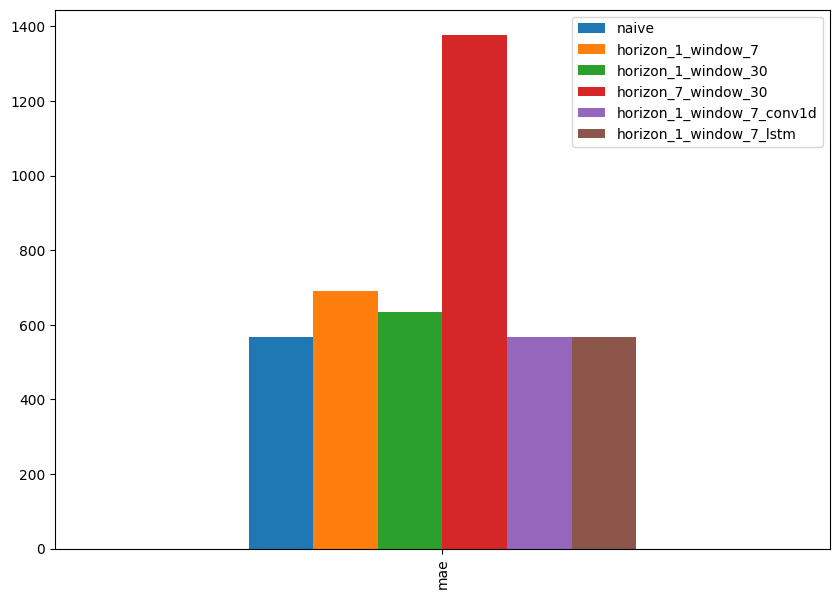

In [73]:
import pandas as pd
pd.DataFrame({
    "naive":naive_results["mae"]
    ,"horizon_1_window_7":model_1_results["mae"]
    ,"horizon_1_window_30":model_2_results["mae"]
    ,"horizon_7_window_30":model_3_results["mae"]
    ,"horizon_1_window_7_conv1d":model_4_results["mae"]
    ,"horizon_1_window_7_lstm":model_5_results["mae"]
},index=["mae"]).plot(figsize=(10,7),kind="bar");

## Make a Multivariate Time Series
Since we are dealing with Bitcoin prices, let's use the **Bitcoin Block Reward** as another bit of information that we can add to our timeseries dataset.

**Bitcoin Block Reward**: The number of blocks that someone receives by mining a Bitcoin Block.

The historical data shows, the number of blocks rewarded have halved every 4 years.

Block Reward|Start Date
---|---
50|03-January-2009(2009-01-03)
25|28-November-2012
12.5|9-July-2016
6.5|11-May-2020
3.125|TBA(Expected 2024)
1.5625|TBA(Expected 2028)


In [74]:
block_reward_1= 50
block_reward_2= 25
block_reward_3= 12.5
block_reward_4= 6.5

## Block Reward dates
block_reward_2_datetime=np.datetime64("2012-11-28")
block_reward_3_datetime=np.datetime64("2016-07-09")
block_reward_4_datetime=np.datetime64("2020-05-11")


From the above information, we should be able to get the block rewards applicable for each day in our dataset

In [75]:
# Get date indexes for when to add in a different block dates
block_reward_2_days= (block_reward_3_datetime-daily_price_df.index[0]).days
block_reward_3_days= (block_reward_4_datetime-daily_price_df.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

Now we can add another feature to our dataset `block_reward`

In [76]:
daily_prices_block = daily_price_df.copy()
daily_prices_block["block_reward"] = None

#Set values of block_reward column
daily_prices_block.iloc[:block_reward_2_days:,-1]= block_reward_2
daily_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1]= block_reward_3
daily_prices_block.iloc[block_reward_3_days:,-1]= block_reward_4

In [77]:
daily_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


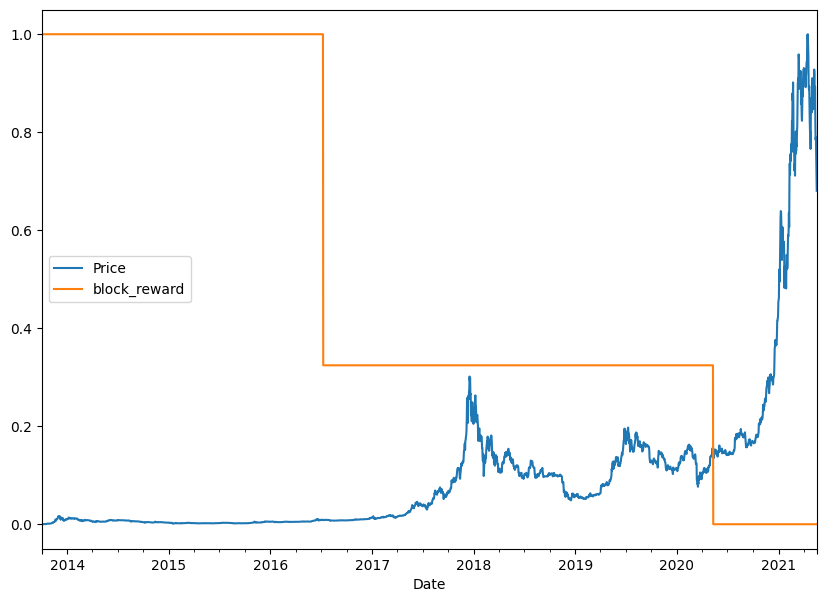

In [78]:
# Plot the block reward/price over time
from sklearn.preprocessing import minmax_scale
scaled_daily_price_block= pd.DataFrame(minmax_scale(daily_prices_block[["Price","block_reward"]])
                                       ,columns=daily_prices_block.columns
                                       ,index=daily_prices_block.index)
scaled_daily_price_block.plot(figsize=(10,7));

## Making a windowed dataset with pandas
Since, our data is in pandas dataframe, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** dataset

In [79]:
HORIZON= 1
WINDOW_SIZE= 7

bitcoin_price_windowed = daily_prices_block.copy()

# Add window columns
for i in range(WINDOW_SIZE):
  bitcoin_price_windowed[f"Price+{i+1}"]= bitcoin_price_windowed["Price"].shift(periods=i+1)

bitcoin_price_windowed.head(20)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


We will now remove the `NaN` values using pandas `dropna()` and create your feature and target columns


In [80]:
X = bitcoin_price_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y = bitcoin_price_windowed.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [81]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [82]:
## Create the train and test dataset
split_size = int(0.8*len(X))
X_train,y_train = X[:split_size],y[:split_size]
X_test, y_test= X[split_size:],y[split_size:]
len(X_train),len(X_test),len(y_train),len(y_test)

(2224, 556, 2224, 556)

## Model 6: Dense ( Multivariate time series)

In [83]:
import tensorflow as tf
from tensorflow.keras import layers

# set random seed
tf.random.set_seed(42)

model_6= tf.keras.Sequential([
    layers.Dense(128,activation="relu")
    ,layers.Dense(HORIZON)
],name="model_6_multivariate_dense")

model_6.compile(loss="mae"
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"])

history_6= model_6.fit(X_train
                       ,y_train
                       ,validation_data=(X_test,y_test)
                       ,epochs=100
                       ,batch_size=32
                       ,verbose=1
                       ,callbacks=[create_model_checkpoint(model_name=model_6.name)]
                      )


Epoch 1/100
59/70 [========================>.....] - ETA: 0s - loss: 562.9416 - mae: 562.9416

70/70 [==============================] - 2s 12ms/step - loss: 508.4549 - mae: 508.4549 - val_loss: 1142.1849 - val_mae: 1142.1849
Epoch 2/100
54/70 [======================>.......] - ETA: 0s - loss: 185.9330 - mae: 185.9330

70/70 [==============================] - 1s 10ms/step - loss: 181.7525 - mae: 181.7525 - val_loss: 886.8249 - val_mae: 886.8249
Epoch 3/100
56/70 [=======================>......] - ETA: 0s - loss: 161.0832 - mae: 161.0832

70/70 [==============================] - 1s 10ms/step - loss: 159.0966 - mae: 159.0966 - val_loss: 800.0026 - val_mae: 800.0026
Epoch 4/100
60/70 [========================>.....] - ETA: 0s - loss: 146.7040 - mae: 146.7040

70/70 [==============================] - 1s 10ms/step - loss: 144.0020 - mae: 144.0020 - val_loss: 719.1448 - val_mae: 719.1448
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 138.8050 - mae: 138.8050 - val_loss: 740.9343 - val_mae: 740.9343
Epoch 6/100
70/70 [==============================] - 0s 5ms/step - loss: 124.7667 - mae: 124.7667 - val_loss: 777.4442 - val_mae: 777.4442
Epoch 7/100
61/70 [=========================>....] - ETA: 0s - loss: 137.1893 - mae: 137.1893

70/70 [==============================] - 1s 15ms/step - loss: 136.0647 - mae: 136.0647 - val_loss: 674.7877 - val_mae: 674.7877
Epoch 8/100
70/70 [==============================] - 0s 5ms/step - loss: 122.5176 - mae: 122.5176 - val_loss: 777.9025 - val_mae: 777.9025
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 118.3141 - mae: 118.3141 - val_loss: 971.2234 - val_mae: 971.2234
Epoch 10/100
68/70 [============================>.] - ETA: 0s - loss: 123.9874 - mae: 123.9874

70/70 [==============================] - 1s 11ms/step - loss: 124.4580 - mae: 124.4580 - val_loss: 630.2278 - val_mae: 630.2278
Epoch 11/100
70/70 [==============================] - 0s 4ms/step - loss: 116.9372 - mae: 116.9372 - val_loss: 767.5084 - val_mae: 767.5084
Epoch 12/100
70/70 [==============================] - 0s 4ms/step - loss: 125.6213 - mae: 125.6213 - val_loss: 659.1779 - val_mae: 659.1779
Epoch 13/100
56/70 [=======================>......] - ETA: 0s - loss: 120.8210 - mae: 120.8210

70/70 [==============================] - 1s 10ms/step - loss: 118.5806 - mae: 118.5806 - val_loss: 630.1017 - val_mae: 630.1017
Epoch 14/100
70/70 [==============================] - 0s 3ms/step - loss: 134.6516 - mae: 134.6516 - val_loss: 1052.9360 - val_mae: 1052.9360
Epoch 15/100
70/70 [==============================] - 0s 3ms/step - loss: 130.0253 - mae: 130.0253 - val_loss: 659.7738 - val_mae: 659.7738
Epoch 16/100
52/70 [=====================>........] - ETA: 0s - loss: 122.1961 - mae: 122.1961

70/70 [==============================] - 1s 10ms/step - loss: 121.0037 - mae: 121.0037 - val_loss: 591.4731 - val_mae: 591.4731
Epoch 17/100
70/70 [==============================] - 0s 3ms/step - loss: 114.5511 - mae: 114.5511 - val_loss: 726.7453 - val_mae: 726.7453
Epoch 18/100
70/70 [==============================] - 0s 4ms/step - loss: 131.6928 - mae: 131.6928 - val_loss: 621.6832 - val_mae: 621.6832
Epoch 19/100
70/70 [==============================] - ETA: 0s - loss: 114.8957 - mae: 114.8957

70/70 [==============================] - 1s 10ms/step - loss: 114.8957 - mae: 114.8957 - val_loss: 579.7901 - val_mae: 579.7901
Epoch 20/100
70/70 [==============================] - 0s 4ms/step - loss: 114.8301 - mae: 114.8301 - val_loss: 801.6882 - val_mae: 801.6882
Epoch 21/100
56/70 [=======================>......] - ETA: 0s - loss: 117.3831 - mae: 117.3831

70/70 [==============================] - 1s 15ms/step - loss: 116.6884 - mae: 116.6884 - val_loss: 577.2198 - val_mae: 577.2198
Epoch 22/100
59/70 [========================>.....] - ETA: 0s - loss: 116.1232 - mae: 116.1232

70/70 [==============================] - 1s 10ms/step - loss: 113.6204 - mae: 113.6204 - val_loss: 572.4231 - val_mae: 572.4231
Epoch 23/100
70/70 [==============================] - 0s 4ms/step - loss: 117.0039 - mae: 117.0039 - val_loss: 609.9683 - val_mae: 609.9683
Epoch 24/100
59/70 [========================>.....] - ETA: 0s - loss: 115.7381 - mae: 115.7381

70/70 [==============================] - 1s 10ms/step - loss: 113.8310 - mae: 113.8310 - val_loss: 572.0463 - val_mae: 572.0463
Epoch 25/100
70/70 [==============================] - 0s 4ms/step - loss: 121.5498 - mae: 121.5498 - val_loss: 668.2267 - val_mae: 668.2267
Epoch 26/100
70/70 [==============================] - 0s 4ms/step - loss: 114.0769 - mae: 114.0769 - val_loss: 578.4280 - val_mae: 578.4280
Epoch 27/100
70/70 [==============================] - 0s 3ms/step - loss: 110.6333 - mae: 110.6333 - val_loss: 575.1997 - val_mae: 575.1997
Epoch 28/100
56/70 [=======================>......] - ETA: 0s - loss: 112.4822 - mae: 112.4822

70/70 [==============================] - 1s 10ms/step - loss: 115.3273 - mae: 115.3273 - val_loss: 566.9539 - val_mae: 566.9539
Epoch 29/100
70/70 [==============================] - 0s 3ms/step - loss: 117.4685 - mae: 117.4685 - val_loss: 581.1703 - val_mae: 581.1703
Epoch 30/100
70/70 [==============================] - 0s 4ms/step - loss: 119.5432 - mae: 119.5432 - val_loss: 574.9265 - val_mae: 574.9265
Epoch 31/100
70/70 [==============================] - 0s 4ms/step - loss: 113.4096 - mae: 113.4096 - val_loss: 812.3270 - val_mae: 812.3270
Epoch 32/100
70/70 [==============================] - 0s 4ms/step - loss: 114.0726 - mae: 114.0726 - val_loss: 577.3081 - val_mae: 577.3081
Epoch 33/100
70/70 [==============================] - 0s 4ms/step - loss: 117.7146 - mae: 117.7146 - val_loss: 577.5062 - val_mae: 577.5062
Epoch 34/100
70/70 [==============================] - 0s 5ms/step - loss: 125.2659 - mae: 125.2659 - val_loss: 668.3058 - val_mae: 668.3058
Epoch 35/100
67/70 [============

70/70 [==============================] - 1s 14ms/step - loss: 112.4384 - mae: 112.4384 - val_loss: 563.5954 - val_mae: 563.5954
Epoch 36/100
70/70 [==============================] - 0s 5ms/step - loss: 113.8920 - mae: 113.8920 - val_loss: 881.5597 - val_mae: 881.5597
Epoch 37/100
70/70 [==============================] - 0s 5ms/step - loss: 117.4609 - mae: 117.4609 - val_loss: 567.1014 - val_mae: 567.1014
Epoch 38/100
70/70 [==============================] - 0s 4ms/step - loss: 117.8257 - mae: 117.8257 - val_loss: 618.3096 - val_mae: 618.3096
Epoch 39/100
70/70 [==============================] - 0s 4ms/step - loss: 110.4578 - mae: 110.4578 - val_loss: 570.5229 - val_mae: 570.5229
Epoch 40/100
70/70 [==============================] - 0s 4ms/step - loss: 116.8228 - mae: 116.8228 - val_loss: 720.7378 - val_mae: 720.7378
Epoch 41/100
70/70 [==============================] - 0s 3ms/step - loss: 112.2857 - mae: 112.2857 - val_loss: 899.0878 - val_mae: 899.0878
Epoch 42/100
70/70 [============

70/70 [==============================] - 1s 10ms/step - loss: 110.1919 - mae: 110.1919 - val_loss: 560.8545 - val_mae: 560.8545
Epoch 45/100
70/70 [==============================] - 0s 4ms/step - loss: 114.1694 - mae: 114.1694 - val_loss: 598.4210 - val_mae: 598.4210
Epoch 46/100
70/70 [==============================] - 0s 4ms/step - loss: 129.3306 - mae: 129.3306 - val_loss: 592.3270 - val_mae: 592.3270
Epoch 47/100
70/70 [==============================] - 0s 4ms/step - loss: 115.3130 - mae: 115.3130 - val_loss: 798.8929 - val_mae: 798.8929
Epoch 48/100
70/70 [==============================] - 0s 3ms/step - loss: 130.7088 - mae: 130.7088 - val_loss: 566.4863 - val_mae: 566.4863
Epoch 49/100
70/70 [==============================] - 0s 4ms/step - loss: 122.1869 - mae: 122.1869 - val_loss: 582.8178 - val_mae: 582.8178
Epoch 50/100
70/70 [==============================] - 0s 4ms/step - loss: 113.2682 - mae: 113.2682 - val_loss: 631.1759 - val_mae: 631.1759
Epoch 51/100
70/70 [============

In [84]:
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 680.2460 - mae: 680.2460


[680.2459716796875, 680.2459716796875]

In [85]:
## Load the best model
saved_multivariate_model = tf.keras.models.load_model("/content/model_experiment/model_6_multivariate_dense")
saved_multivariate_model.evaluate(X_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 560.8545 - mae: 560.8545


[560.8544921875, 560.8544921875]

In [86]:
model_6_preds = make_preds(saved_multivariate_model,X_test)

18/18 [==============================] - 0s 2ms/step


In [87]:
model_6_results= evaluate_preds(y_true=y_test
                                ,y_pred=model_6_preds)
model_6_results

{'mse': 1144884.0,
 'rmse': 1069.9926,
 'mase': 0.9852659,
 'mape': 2.521038,
 'mae': 560.85443}

## Model 7: N-Beats Algorithm

We will replicate the generic architecture in N-Beats paper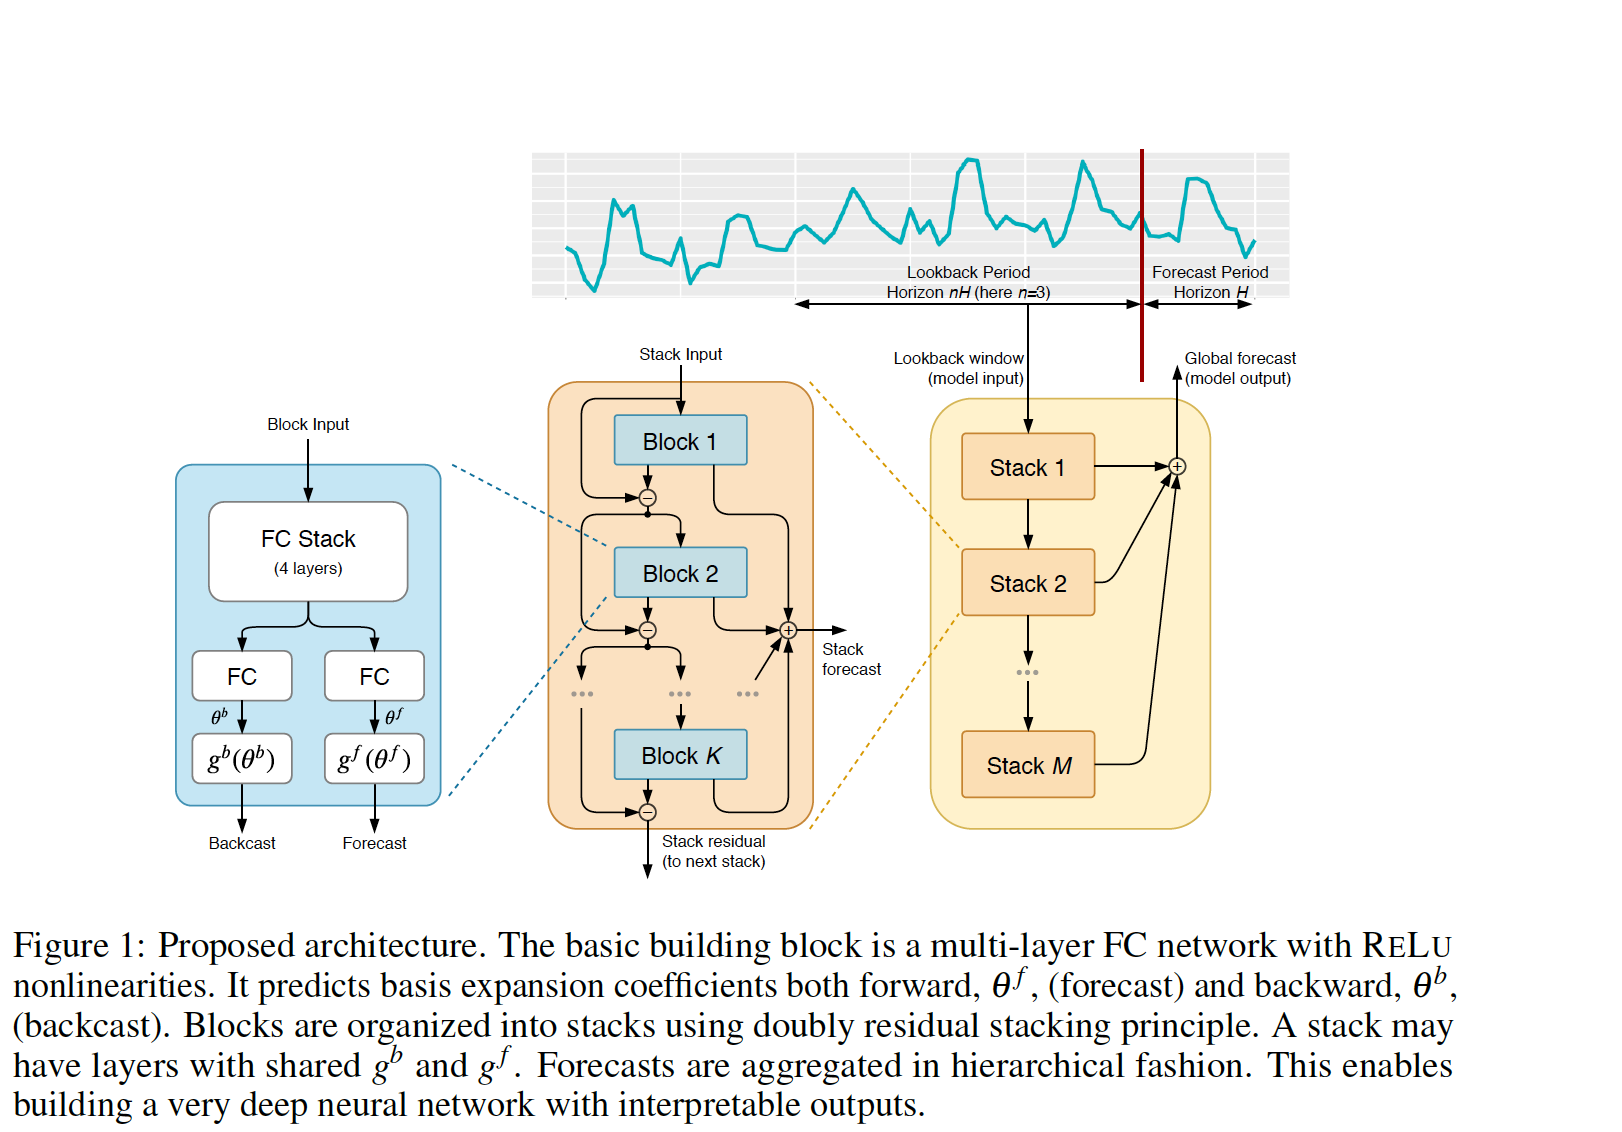

Building & Testing an N-Beats block layer


In [125]:
# Create a NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self
               ,input_size: int
               ,theta_size: int
               ,horizon: int
               ,n_neurons: int
               ,n_layers: int
               ,**kwargs):
    super().__init__(**kwargs)
    self.input_size= input_size
    self.theta_size= theta_size
    self.horizon= horizon
    self.n_neurons= n_neurons
    self.n_layers= layers
    ## Block contains stack of 4 fully connected layers each with ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons,activation="relu") for _ in range(n_layers)]
    ## Output block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear",name="theta")

  def call(self,inputs):
    x= inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    # output the backcast and forecast from theta
    backcast, forecast= theta[:,:self.input_size], theta[:,-self.horizon:]
    return backcast, forecast


In [126]:
dummy_nbeats_block_layer= NBeatsBlock(input_size=WINDOW_SIZE
                                      ,theta_size=WINDOW_SIZE+HORIZON
                                      ,horizon=HORIZON
                                      ,n_neurons=128
                                      ,n_layers=4)

In [127]:
# Create the dummy input
dummy_inputs= tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [128]:
## Pass the dummy inputs to the dummy NBeatsBlock layer
backcast, forecast= dummy_nbeats_block_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.26715288 -0.03345594  0.06904665 -0.21937764  0.19176845 -0.13349433
 -0.11029354]
Forecast: -0.8476499319076538


In [137]:
daily_price_df.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [138]:
daily_price_nbeat = daily_price_df.copy()
for i in range(WINDOW_SIZE):
  daily_price_nbeat[f"Price-{i+1}"] = daily_price_nbeat["Price"].shift(periods=i+1)

daily_price_nbeat.dropna().head()

,Price,Price-1,Price-2,Price-3,Price-4,Price-5,Price-6,Price-7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [142]:
X = daily_price_nbeat.dropna().drop(["Price"],axis=1)
y = daily_price_nbeat.dropna()[["Price"]]

split_size= int(0.8 * len(X))
X_train, y_train = X[:split_size],y[:split_size]
X_test,y_test= X[split_size:], y[split_size:]

len(X_train),len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [143]:
# Turn train and test arrays into tensor Datasets
train_features_dataset= tf.data.Dataset.from_tensor_slices(X_train)
test_features_dataset= tf.data.Dataset.from_tensor_slices(X_test)

train_labels_dataset= tf.data.Dataset.from_tensor_slices(y_train)
test_labels_dataset= tf.data.Dataset.from_tensor_slices(y_test)

# Zip the features and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset,train_labels_dataset))
test_dataset= tf.data.Dataset.zip((test_features_dataset,test_labels_dataset))

## BATCH & PREFETCH for optimal perfomance
BATCH_SIZE= 1024
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset= test_dataset.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset,test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [144]:
# Hyperparameters from N-Beats paper
N_EPOCHS= 5000
N_LAYERS= 4
N_NEURONS= 512
N_STACKS= 30

INPUT_SIZE= WINDOW_SIZE * HORIZON
THETA_SIZE= INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connection
In the case of N-BEATS, the architecture uses residual connections which:
* Substract the backcast outputs from a previous block from the backcast inputs to the current block.
* Add the forecast outputs from all blocks together in a stack.


In [145]:
#set random seed
tf.random.set_seed(42)

# 1. Setup N-BEATS block layer
nbeats_block_layer= NBeatsBlock(input_size=INPUT_SIZE
                                ,theta_size= THETA_SIZE
                                ,horizon= HORIZON
                                ,n_neurons= N_NEURONS
                                ,n_layers= N_LAYERS
                                ,name="InitialBlock")

# 2. Create input to stack
stack_input= layers.Input(shape=(INPUT_SIZE),name="stack_input")

# 3. Create initial backcast and forecast input
backcast, forecast= nbeats_block_layer(stack_input)

# Add in substraction residual link
residuals= layers.subtract([stack_input,backcast],name=f"substract_00")

# 4. Create stack of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in #3
  #5 Use the NBeatsBlock to calculate the backcast as well as the block forecast
  backcast, block_forecast= NBeatsBlock(input_size=INPUT_SIZE
                                        ,theta_size=THETA_SIZE
                                        ,horizon= HORIZON
                                        ,n_neurons= N_NEURONS
                                        ,n_layers= N_LAYERS
                                        ,name=f"NBeatsBlock-{i}")(residuals)

# 6. Create the double residual stacking
residuals= layers.subtract([residuals,backcast],name=f"substract-{i}")
forecast= layers.add([residuals,block_forecast],name=f"add-{i}")

# 7. Put the stack model together
model_7= tf.keras.Model(inputs=stack_input
                        ,outputs=forecast
                        ,name="model_7_nbeats")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae"
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callback
model_7.fit(train_dataset
            ,epochs=N_EPOCHS
            ,validation_data=test_dataset
            ,verbose=0
            ,callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor="val_loss"
                                                 ,patience=200
                                                 ,restore_best_weights=True)
                ,tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss"
                                                      ,patience=100
                                                      ,verbose=1)])


Epoch 454: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 554: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [146]:
model_7.evaluate(X_test,y_test)

18/18 [==============================] - 0s 8ms/step - loss: 596.3067 - mae: 596.3067


[596.3067016601562, 596.3067016601562]

In [148]:
model_7_preds = make_preds(model_7,X_test)
model_7_preds[:10]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[8760.363 , 8901.521 , 8832.725 , 8880.103 , 8817.481 , 8741.51  ,
        8911.782 ],
       [8752.694 , 8730.34  , 8826.214 , 8771.261 , 8749.84  , 8736.584 ,
        8797.656 ],
       [9053.252 , 9051.322 , 8908.227 , 9066.04  , 9039.613 , 8980.705 ,
        9099.327 ],
       [8691.66  , 8876.746 , 8658.969 , 8740.273 , 8791.401 , 8758.791 ,
        8831.446 ],
       [8788.308 , 8724.537 , 8923.774 , 8728.052 , 8763.957 , 8748.989 ,
        8858.488 ],
       [8763.016 , 8869.062 , 8655.515 , 8913.954 , 8722.695 , 8635.199 ,
        8924.015 ],
       [8605.98  , 8657.276 , 8631.883 , 8580.678 , 8682.7   , 8558.905 ,
        8666.504 ],
       [8460.154 , 8549.954 , 8502.066 , 8518.727 , 8447.677 , 8556.975 ,
        8495.749 ],
       [8478.197 , 8522.958 , 8495.17  , 8521.354 , 8487.1045, 8370.119 ,
        8620.142 ],
       [8497.408 , 8532.337 , 8454.163 , 8513.144 , 8500.699 , 8479.097 ,
        8538.818 ]], dtype=floa

In [149]:
model_7_results = evaluate_preds(y_true=y_test
                                 ,y_pred=model_7_preds)
model_7_results


{'mse': 1204186.5,
 'rmse': 623.5417,
 'mase': 1.0475457,
 'mape': 2.7631898,
 'mae': 596.3067}

In [150]:
model_7.summary()

Model: "model_7_nbeats"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 7)]          0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 7),          796168      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 substract_00 (Subtract)        (None, 7)            0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                     